# Zillow Data Time Series Analysis

In [534]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 - Emily Marsh
 - Self Paced
 - Scheduled Project Review Date/Time:
 - Instructor Name: Morgan Jones

# Introduction

In the United States, a common investment oppurtunity for personal and commercial investment is real estate. In 2023 the average the average annual return on investment for residential real estate in the United States is 10.6 percent. Commercial real estate averages a slightly lower ROI of 9.5 percent, while REITs average a slightly higher 11.8 percent. There have been recent historical events that have had an impact on this annual return on investment. The housing crash in 2011 as well as the COVID pandemic of 2020 have had outsized impacts on pricing of housing, however a consistent increase over time has made this an area of consistent profits. Compass Real Estate, an real estate brokerage company that specializes in high-margin, luxury homes in upscale markets, has commissioned this project to expand into a new lower cost housing market in order to appeal to a broader group of clients and quicker cash flow. 

## Business Objective

Compass Real Estate is interested in investing in lower priced housing, under $300,000, for a smaller but more consistent revenue stream to supplement their luxury housing investments. This will also give the company the chance to expand their client base to more middle class home buyers. However, before investing capitol in this new venture, Compass would like to do analysis into determining the best five zipcodes that provides the biggest chance of profit. Using the dataset, this analysis will provide insight into the five best zip codes for investment as well as the projected profits over the next five years in each zip code. These predication will be made using Time Series modeling. 

## Dataset

The dataset used for this project is a subset of a larger dataset from Zillow, and consists of **14,732 rows** and **272 columns**. The format of the dataset includes features about **RegionID, Region Name (Zipcode), City, State, Metro, County Name, Size Rank**, and the **average price of houses in the zipcode starting in April of 1994 and ending with April of 2018**. Each **RegionName/Zipcode** is a unique value, while **Metro and County Name** are not. It is also important to note that the dataset is in a **wide format** versus a **long format**. Therefore in order to pass this data into a model, the dataset will need to be reshaped to a **long format**. 

## Import Libraries

In [535]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [536]:
pip install scalecast --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [537]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [538]:
#Importing necessary Packages

import warnings
import itertools
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
%matplotlib inline
import geopandas as gpd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
from pandas import DataFrame
from pandas import concat
import statsmodels.api as sm
import holidays
import pickle
from scalecast.Forecaster import Forecaster
from tqdm.notebook import tqdm
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
from keras.optimizers import Adam



import warnings
warnings.filterwarnings('ignore')

In [539]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

## Initial Data Exploration

In [540]:
#using CSV reader to read dataframe into pandas

df = pd.read_csv('/content/drive/MyDrive/Flatiron DS Program/Phase Four Project/zillow_data.csv')

In [541]:
#initial overview of datasets columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [542]:
#exploring the total amount of columns and rows in dataset

df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [543]:
#observing values and format of the dataframe
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Data Understanding

Within this dataset, 4 of the features are string values, 49 are integers, and 219 are floats. As was mentioned earlier, this dataset is in a wide format instead of a long format. Long format will be necessary for passing the dataset into a model. Additional investigation will be necessary to determine if there are any null values in the dataset that could interfere with accurate results. 

## Check for Null Values

In [544]:
# checking for null values and returning it as a pandas series
empty=df.isna().sum()
empty.head(20)

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
dtype: int64

After additional investigation, the dataset appears to contain null values in metro and in some of the prices. Since the dataset that will be modeled will be a subset of this dataset, the prescence of null values will be checked again. 

# Data Preparation

The profit of each zip code will be determined by subtracting the original price of the average property in April of 1996 from the average property value in April of 2018. Due to the client's budget, the available houses will be limited by price, only properties with a value of under $300,000 as of April 2018. Since Compass is a national company, geography is not a limiting factor for investment consideration therefore no geographical constraints will be used to limit the available zipcodes. 

## Filtering for Properties Under Client Budget

Since Compass Real Estate is interested in expanding into more middle class housing, the analysis will focus on properties that are under the price of $300,000 as of April 2018.

In [545]:
#creating new dataframe with only properties that are under $300,000 as of 2018-04
client_budget = df[df['2018-04']<=300000]

In [546]:
#Examining new dataframe size with budget restrictions
client_budget

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,249900,250400,249900,248700,247500,247100,246800,247500,249800,251800
14,74101,37013,Nashville,TN,Nashville,Davidson,15,112400.0,112700.0,113000.0,...,193000,194900,196600,198800,201300,203800,205900,207600,210000,211900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14715,62556,12429,Esopus,NY,Kingston,Ulster,14716,78300.0,78300.0,78200.0,...,164200,166600,170000,171000,170700,171300,172400,173600,175800,177500
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122200,122700,122300,122000,122200,122800,123200,123200,120700,117700
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800


Even with the budget limit of $3000,000, Compass Real Estate has many zipcodes to potentially choose from. In order to determine which zipcodes have the greates ROI, a new column will be created to show the total increase in value from April of 1996 to April of 2018.

## Creating Total Price Increase Column to Dataframe

Since the client, Compass Real Estate, is interested in maximizing profits, a new column showing the total increase in price from April of 1996 to April of 2018 will be added to the dataset. As a result, a house that has gained the most value over this time period will be the most desirable for the clients. 

In [547]:
#Creating a new column with April 2018 price minus the price in April of 1996 to show overall value increase over 
#the time period
client_budget.loc[:,'Total Price Increase'] = (
    client_budget['2018-04'] - client_budget['1996-04']
            )

In [548]:
client_budget

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Total Price Increase
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,44200.0
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,158700,160200,161900,162800,162800,162800,162900,163500,164300,69300.0
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,167400,168400,169600,170900,172300,173300,174200,175400,176200,80800.0
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,250400,249900,248700,247500,247100,246800,247500,249800,251800,150800.0
14,74101,37013,Nashville,TN,Nashville,Davidson,15,112400.0,112700.0,113000.0,...,194900,196600,198800,201300,203800,205900,207600,210000,211900,99500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14715,62556,12429,Esopus,NY,Kingston,Ulster,14716,78300.0,78300.0,78200.0,...,166600,170000,171000,170700,171300,172400,173600,175800,177500,99200.0
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122700,122300,122000,122200,122800,123200,123200,120700,117700,55200.0
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,217700,218600,218500,218100,216400,213100,209800,209200,209300,114700.0
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,208400,212200,215200,214300,213100,213700,218300,222700,225800,133100.0


From the limited view of the available 10,632 rows, a range of profits over time are already evident. It will be necessary to order the data by these values to determine which zip codes have the greatest value increase.  

## Ordering By Total Price Increase and Creating a Top 25 Zip Code Dataset

Since the client is limited by resources to only focus on five zipcodes, the top 25 Zip Codes will be modeled to give options for modeling and selecting the top five zip codes that maximize profit. 

In [549]:
#ordering the dataframe from highest value of Total Price Increase to find the top 25 zipcodes 
top_25_zips = client_budget.sort_values(by=['Total Price Increase'], ascending=False).head(25)

In [550]:
#examine new dataframe of top 25 zipcodes according to total price increase
top_25_zips

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Total Price Increase
13830,66102,19951,Harbeson,DE,Salisbury,Sussex,13831,34500.0,34900.0,35200.0,...,258600,258100,260300,265400,269300,272100,275300,277000,276900,242400.0
14217,93399,80449,Hartsel,CO,Denver,Park,14218,30000.0,30400.0,30900.0,...,244600,248000,251300,252900,254700,256600,259200,263400,267700,237700.0
3615,65792,19125,Philadelphia,PA,Philadelphia,Philadelphia,3616,32600.0,32700.0,32800.0,...,249000,251600,253900,255700,257100,258000,258500,260500,262300,229700.0
11353,95177,86334,Paulden,AZ,Prescott,Yavapai,11354,41100.0,41400.0,41700.0,...,229800,232000,237000,242800,249200,253900,257800,263900,269900,228800.0
2656,73011,34120,Naples,FL,Naples,Collier,2657,68600.0,67900.0,67200.0,...,289800,291800,293800,294000,293700,294600,294700,295100,296200,227600.0
8350,92632,78721,Austin,TX,Austin,Travis,8351,69200.0,68800.0,68400.0,...,281200,281500,284000,288500,293000,296300,297800,297200,296100,226900.0
3153,99192,97321,Albany,OR,Albany,Linn,3154,71600.0,71900.0,72200.0,...,286800,288600,289500,289700,290700,292100,293200,295200,297700,226100.0
13470,82893,56511,Audubon,MN,NaN,Becker,13471,59200.0,59300.0,59500.0,...,281000,280500,279100,277700,278100,279800,280100,281400,284300,225100.0
8743,99229,97370,Philomath,OR,Corvallis,Benton,8744,69300.0,69700.0,70000.0,...,278300,281300,284400,287100,290100,292900,293000,291800,291500,222200.0
10598,64752,16827,Boalsburg,PA,State College,Centre,10599,67500.0,67700.0,67900.0,...,274400,277000,278200,279000,279800,279700,280800,284300,287800,220300.0


In [551]:
empty_25=top_25_zips.isna().sum()
empty_25.head(40)

RegionID      0
RegionName    0
City          0
State         0
Metro         2
CountyName    0
SizeRank      0
1996-04       0
1996-05       0
1996-06       0
1996-07       0
1996-08       0
1996-09       0
1996-10       0
1996-11       0
1996-12       0
1997-01       0
1997-02       0
1997-03       0
1997-04       0
1997-05       0
1997-06       0
1997-07       0
1997-08       0
1997-09       0
1997-10       0
1997-11       0
1997-12       0
1998-01       0
1998-02       0
1998-03       0
1998-04       0
1998-05       0
1998-06       0
1998-07       0
1998-08       0
1998-09       0
1998-10       0
1998-11       0
1998-12       0
dtype: int64

After checking, the Top 25 Zip Codes dataset only contains two null values in the Metro column. This feature column is unimportant to the modeling process as this feature will be dropped in favor of using RegionName/Zipcode. 

## Visualizing the Geographic Spread of the Top 25 Zip Codes

Despite the client, Compass Real Estate, not being limited to geographic locations, it is valuable to see any geographic trends among the top 25 zipcodes for potential maximizing of resources. A dataset with latitute and longitude values for each Zipcode will be created in order to create a useful visual. 

In [552]:
#extracting the top 25 Zipcodes from the dataset
list(top_25_zips['RegionName'])

[19951,
 80449,
 19125,
 86334,
 34120,
 78721,
 97321,
 56511,
 97370,
 16827,
 16801,
 32233,
 86323,
 55409,
 56442,
 80456,
 33947,
 63108,
 56443,
 70734,
 37216,
 57110,
 19968,
 30316,
 33602]

In [553]:
#creating a list of values for the longitude and latitude of each Zipcode
coord = [(19951, 38.6898, -75.24000), (80449, 38.95689,-105.87044), (19125, 39.97641,-75.12217), (86334, 34.94867,-112.54443), 
        (34120, 26.32277,-81.55923),(78721, 30.26619,-97.68476), (97321, 44.63339,-123.13956), (56511, 46.84768,-96.01409), (97370, 44.59613,-123.45873), 
         (16827, 40.77297,-77.76024), (16801, 40.78681,-77.84438), (32233, 30.36143,-81.42642), (86323, 34.83896,-112.39677), (55409, 44.92652,-93.29081), (56442, 46.68866,-94.09915),
        (80456, 39.35346,-105.77032), (33947, 26.88093,-82.26993), (63108, 38.64461,-90.25198), (56443, 46.19521,-94.55463), (70734, 30.20703,-91.00902),
        (37216, 36.21681,-86.72443), (57110, 43.54969,-96.63113), (19968, 38.76454,-75.29784), (30316, 33.71759,-84.33225), (33602, 27.94946,-82.46118)]

In [554]:
#creating a dataframe with the longitude, latitude, and RegionName values
zip_long_lat = pd.DataFrame(coord, columns=['RegionName', 'Latitude', 'Longitude'])

In [555]:
#examining dataframe
zip_long_lat

,RegionName,Latitude,Longitude
0,19951,38.68980,-75.24000
1,80449,38.95689,-105.87044
2,19125,39.97641,-75.12217
3,86334,34.94867,-112.54443
4,34120,26.32277,-81.55923
5,78721,30.26619,-97.68476
6,97321,44.63339,-123.13956
7,56511,46.84768,-96.01409
8,97370,44.59613,-123.45873
9,16827,40.77297,-77.76024


In [556]:
#merging the latitude and longitude dataframe with the Top 25 Zipcode Dataframe
top_25_full_df = pd.merge(top_25_zips, zip_long_lat, on=["RegionName"])

In [557]:
#examining new full dataset
top_25_full_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Total Price Increase,Latitude,Longitude
0,66102,19951,Harbeson,DE,Salisbury,Sussex,13831,34500.0,34900.0,35200.0,...,260300,265400,269300,272100,275300,277000,276900,242400.0,38.68980,-75.24000
1,93399,80449,Hartsel,CO,Denver,Park,14218,30000.0,30400.0,30900.0,...,251300,252900,254700,256600,259200,263400,267700,237700.0,38.95689,-105.87044
2,65792,19125,Philadelphia,PA,Philadelphia,Philadelphia,3616,32600.0,32700.0,32800.0,...,253900,255700,257100,258000,258500,260500,262300,229700.0,39.97641,-75.12217
3,95177,86334,Paulden,AZ,Prescott,Yavapai,11354,41100.0,41400.0,41700.0,...,237000,242800,249200,253900,257800,263900,269900,228800.0,34.94867,-112.54443
4,73011,34120,Naples,FL,Naples,Collier,2657,68600.0,67900.0,67200.0,...,293800,294000,293700,294600,294700,295100,296200,227600.0,26.32277,-81.55923
5,92632,78721,Austin,TX,Austin,Travis,8351,69200.0,68800.0,68400.0,...,284000,288500,293000,296300,297800,297200,296100,226900.0,30.26619,-97.68476
6,99192,97321,Albany,OR,Albany,Linn,3154,71600.0,71900.0,72200.0,...,289500,289700,290700,292100,293200,295200,297700,226100.0,44.63339,-123.13956
7,82893,56511,Audubon,MN,NaN,Becker,13471,59200.0,59300.0,59500.0,...,279100,277700,278100,279800,280100,281400,284300,225100.0,46.84768,-96.01409
8,99229,97370,Philomath,OR,Corvallis,Benton,8744,69300.0,69700.0,70000.0,...,284400,287100,290100,292900,293000,291800,291500,222200.0,44.59613,-123.45873
9,64752,16827,Boalsburg,PA,State College,Centre,10599,67500.0,67700.0,67900.0,...,278200,279000,279800,279700,280800,284300,287800,220300.0,40.77297,-77.76024


In [558]:
#Importing shp of the USA map for visualization
mapdf = top_25_full_df.copy()

usa_map = gpd.read_file('/content/drive/MyDrive/Flatiron DS Program/Phase Four Project/tl_2017_us_state/tl_2017_us_state.shp')
usa_map = usa_map.to_crs("EPSG:4326")

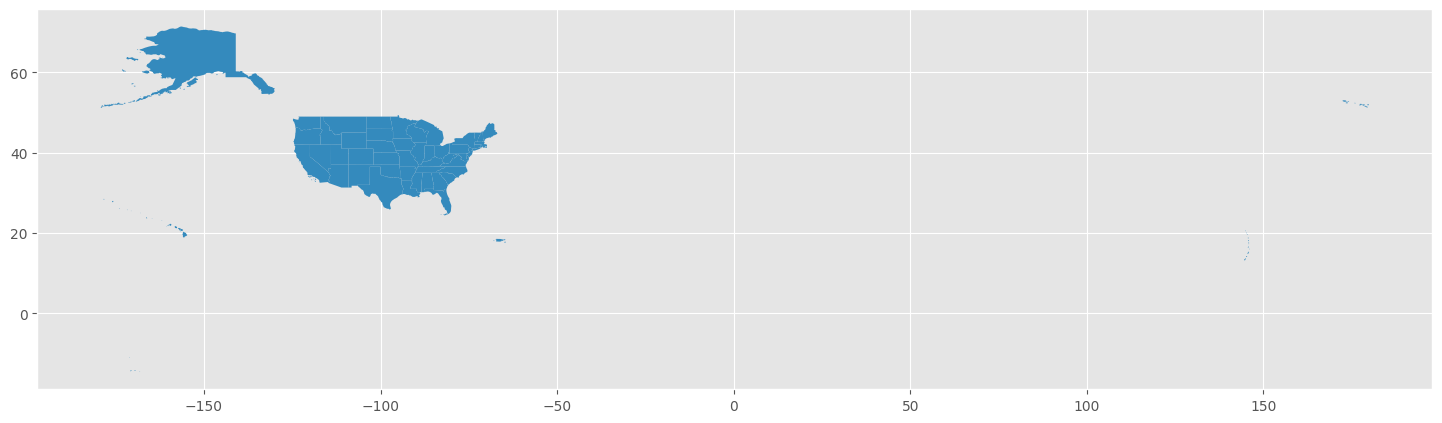

In [559]:
#examining SHP file
usa_map.plot();

In [560]:
#Removing Non Continental States from Visualization
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = usa_map
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

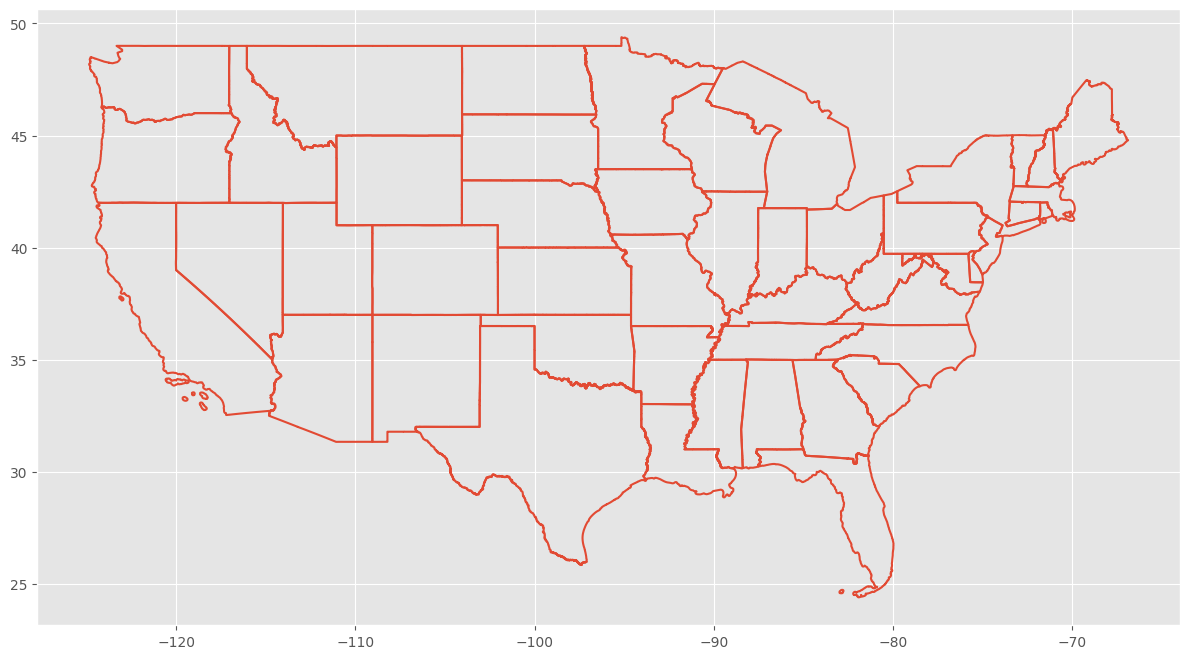

In [561]:
#examining new chart
us49.boundary.plot()
plt.show()

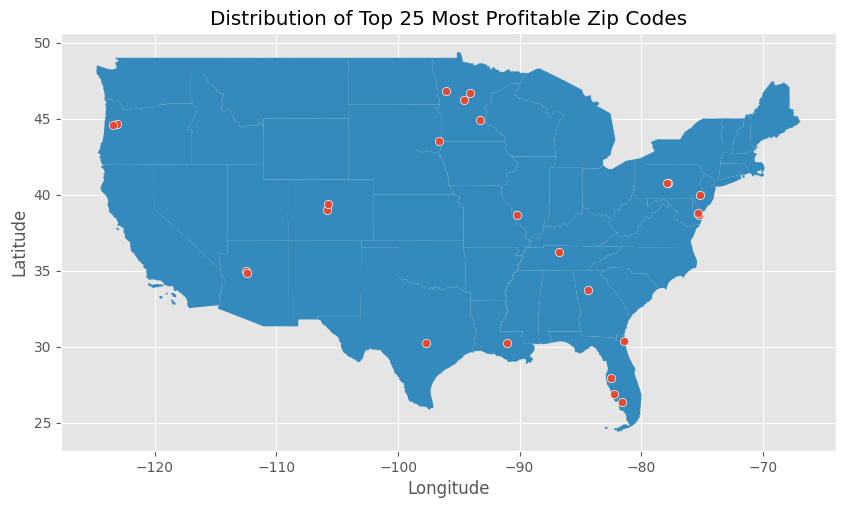

In [562]:
#Plotting the Top 25 Zip Codes on USA Chart
crs = {'init':'EPSG:4326'} #define CRS
geometry = [Point(xy) for xy in zip(mapdf['Longitude'], top_25_full_df['Latitude'])] #create Points
geo_df = gpd.GeoDataFrame(mapdf, 
                          crs = crs, 
                          geometry = geometry) #define the geometry df

#plot the data
fig, ax = plt.subplots(figsize = (10,10))
us49.to_crs(epsg=4326).plot(ax=ax)
sns.scatterplot(x="Longitude", y="Latitude",data=mapdf, ax=ax)
ax.set_title('Distribution of Top 25 Most Profitable Zip Codes');

As can be seen on the chart, there are some interesting geographic concentrations that could be of interest to the clients if there was a desire to consolidate resources geographically. The analysis of this project, however, will move forward with recommendations based solely on ROI considerations with no geographic consideration. 

## Visualizing the Price history of filtered Zip Codes since 1996

An important aspect of times series data anlysis is making sure that the modeling is not overall affected by seasonality or trends within the data. To get a better sense of the shape of the price history, a visualization of the price history since 1996 will be utilized.

In [563]:
#creating a function to convert the dataset from wide format to long format
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby(['time']).aggregate({'value':'mean'})

In [564]:
#drop extra columns not needed for modeling
top_25_modeling_df = top_25_full_df.drop(['Total Price Increase', 'Latitude', 'Longitude'], axis=1)

In [565]:
#examine new dataset with dropped columns for modeling
top_25_modeling_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,66102,19951,Harbeson,DE,Salisbury,Sussex,13831,34500.0,34900.0,35200.0,...,260000,258600,258100,260300,265400,269300,272100,275300,277000,276900
1,93399,80449,Hartsel,CO,Denver,Park,14218,30000.0,30400.0,30900.0,...,243200,244600,248000,251300,252900,254700,256600,259200,263400,267700
2,65792,19125,Philadelphia,PA,Philadelphia,Philadelphia,3616,32600.0,32700.0,32800.0,...,247500,249000,251600,253900,255700,257100,258000,258500,260500,262300
3,95177,86334,Paulden,AZ,Prescott,Yavapai,11354,41100.0,41400.0,41700.0,...,230300,229800,232000,237000,242800,249200,253900,257800,263900,269900
4,73011,34120,Naples,FL,Naples,Collier,2657,68600.0,67900.0,67200.0,...,288300,289800,291800,293800,294000,293700,294600,294700,295100,296200


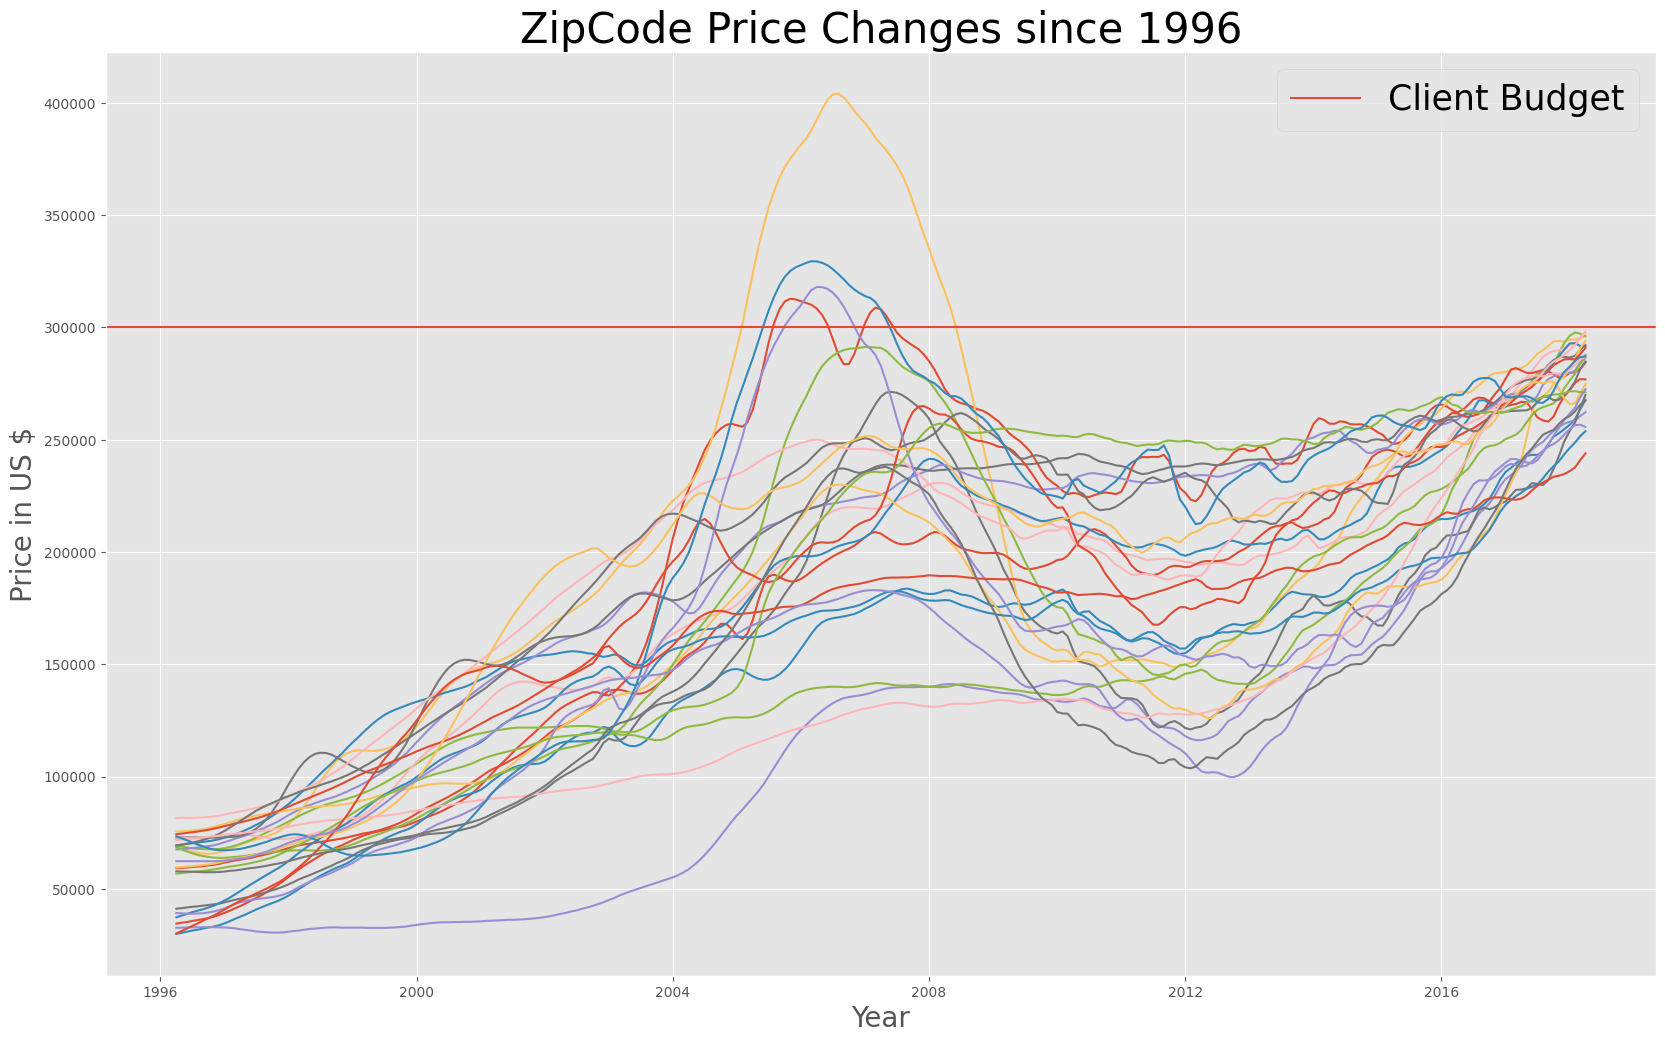

In [566]:
#creating plot of prices changes by zipcode since 1996
zip_dict = {}

for zipcode in top_25_modeling_df['RegionName']:
    zip_dict[zipcode] = melt_data(top_25_modeling_df[top_25_modeling_df['RegionName']==zipcode])

fig,ax = plt.subplots(figsize=(20,12))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode],)

ax.axhline(y=300000,label = 'Client Budget')   

ax.set_title('ZipCode Price Changes since 1996',fontsize=30)
ax.set_ylabel('Price in US $',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.legend(prop={'size': 25});

As can be seen in the visualization, there was an increase of prices and then a steep decline around 2008. This corresponds with the 2008 financial housing crisis and recession. Since then, it appears that prices have been steadily on the rise since 2011 but have yet to reach their pre-recession peaks. There area also some interesting outliers in the data that grew and declined rapidly around 2008.

## Visualizing the The Zip Codes' Average Price Growth

Creating a visualization of which zipcodes have been growing the fastest since then will be a helpful tool to determine which zipcodes should be used for modeling. 

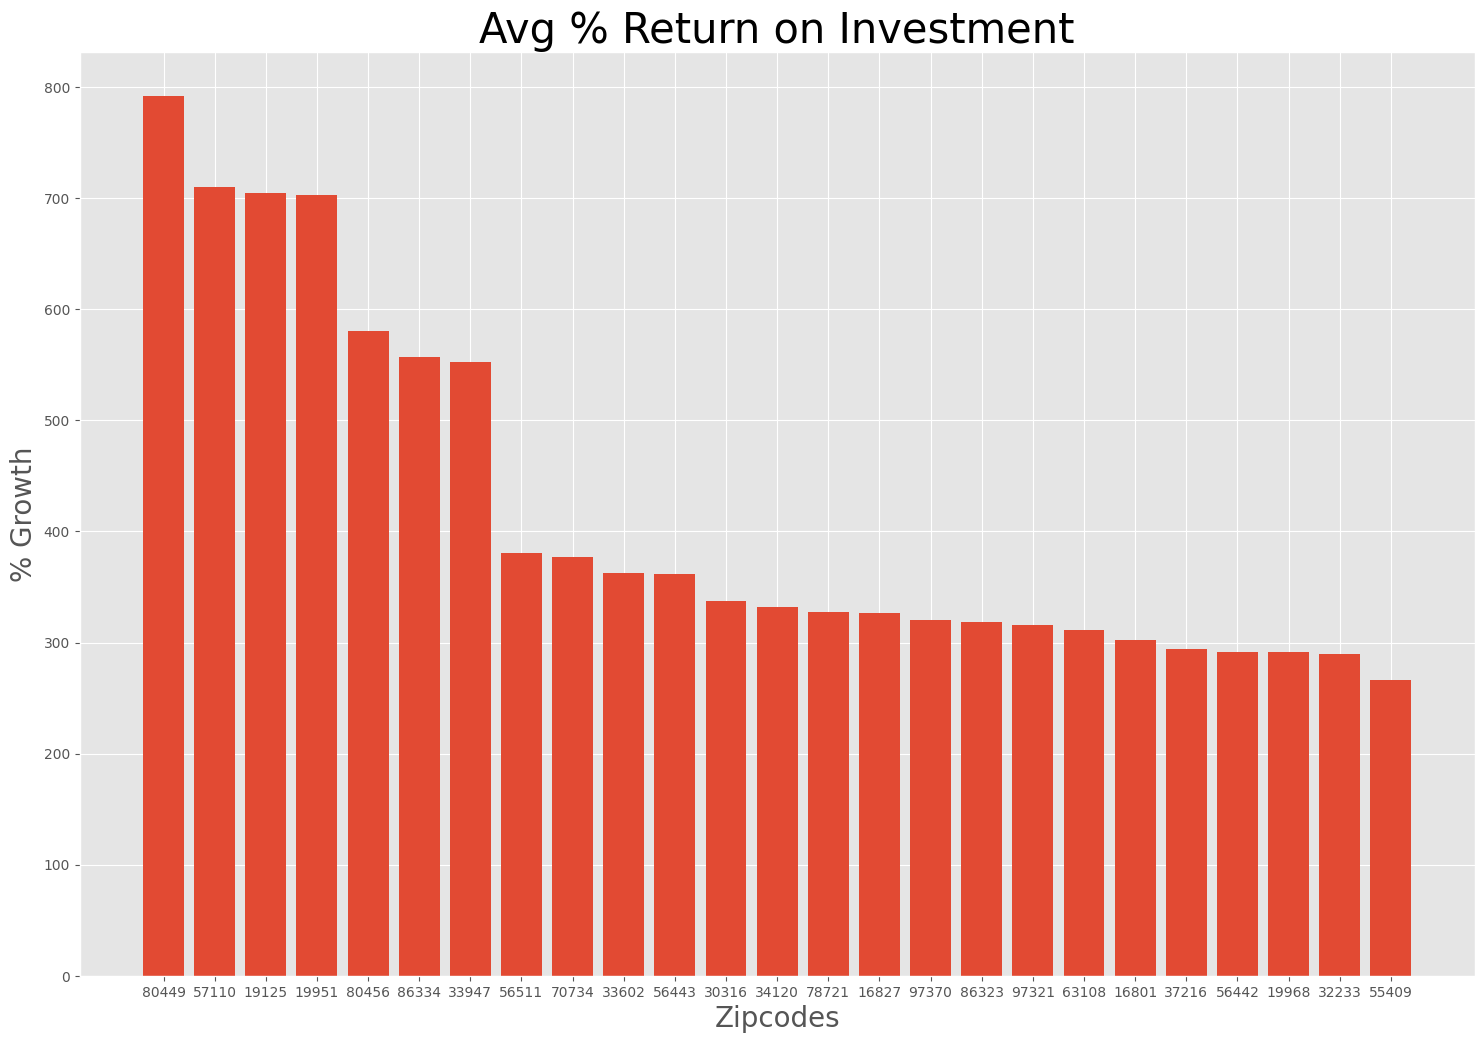

In [567]:
#creating a bar graph visual that shows the average return on investment for each of the top 25 zipcodes
warnings.filterwarnings('ignore')

#creating column with ROI since 2011
top_25_2011_roi = top_25_modeling_df
top_25_2011_roi['roi_since1996'] = (
    (top_25_2011_roi['2018-04']-top_25_2011_roi['1996-04'])/(top_25_2011_roi['1996-04'])*100)
top_25_2011_roi = top_25_2011_roi.sort_values('roi_since1996',ascending=False)

warnings.filterwarnings('ignore')

#plotting column roi_since11 for each zipcode
fig,ax=plt.subplots(figsize=(18,12))

x_labels = [str(a) for a in top_25_2011_roi['RegionName']]
x = list(range(1,26))
y = [a for a in top_25_2011_roi['roi_since1996']]

ax.bar(x,y)

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel('% Growth',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on Investment',fontsize='30');

We can see from above that the highest growing zip code since 1996 is 80449. It is also of interest to note that the top six zipcodes seem concentrated around the same geographic area. Areas of growth not being limited to one zipcode is an interesting oppurtunity for clients to acheive the highest ROI while also concentrating resources. 

# Selecting a ZipCode for the Initial Time Series Model

In order to build a time series model that predicts the future ROI of each of the top 25 zipcodes within the client's budget, an initial time series model must be built on one of the zipcodes in the dataset. Since zipcode 80449 is the fastest growing it will be used to construct the initial time series model. Therefore, the first time series model will predict what the future value of 80449 will be. A similar workflow can then be utilized on the other zipcodes within the dataset to identify which five zipcodes have the highest predicted ROI. 

In [568]:
#dataframe containing zipcode 80449
zip80449 = df[df['RegionName']==80449]

In [569]:
#melting zipcode 80449 from wide to long format
series80449 = melt_data(zip80449)

In [570]:
#examining 80449 long format dataset
series80449

,value
time,
1996-04-01,30000.0
1996-05-01,30400.0
1996-06-01,30900.0
1996-07-01,31400.0
1996-08-01,31800.0
...,...
2017-12-01,254700.0
2018-01-01,256600.0
2018-02-01,259200.0


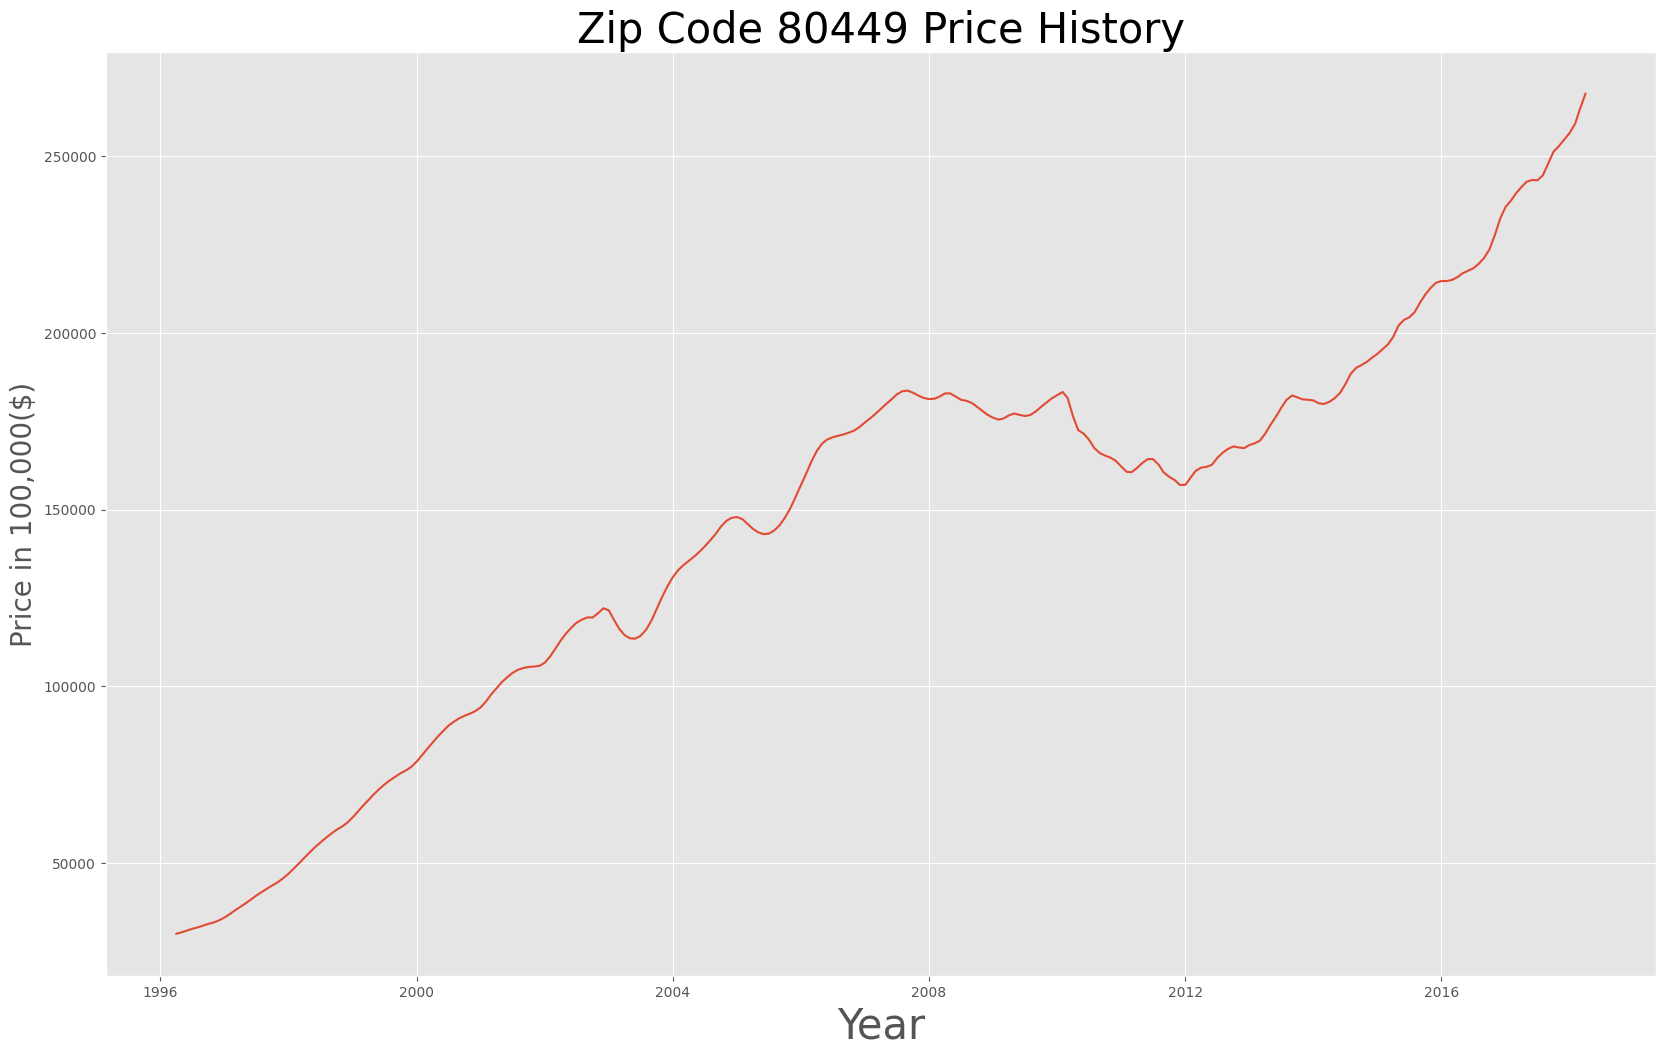

In [571]:
#Visualizing the Time Series Data for zipcode- 80449

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series80449)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 80449 Price History',fontsize=30);

After having examined the price history of all the zipcodes in the top 25 dataset, individually the zipcode of 33602 follows similar patterns. There is a sharp increase in price followed by a small descent around the year 2008, and then continuing a steady increase starting in 2012. As a result, it seems reasonable to expect that a time series model of this individual zipcode will also be successful with the remaining zipcodes in the dataset. 

# Checking for Trends, Stationarity & Seasonality

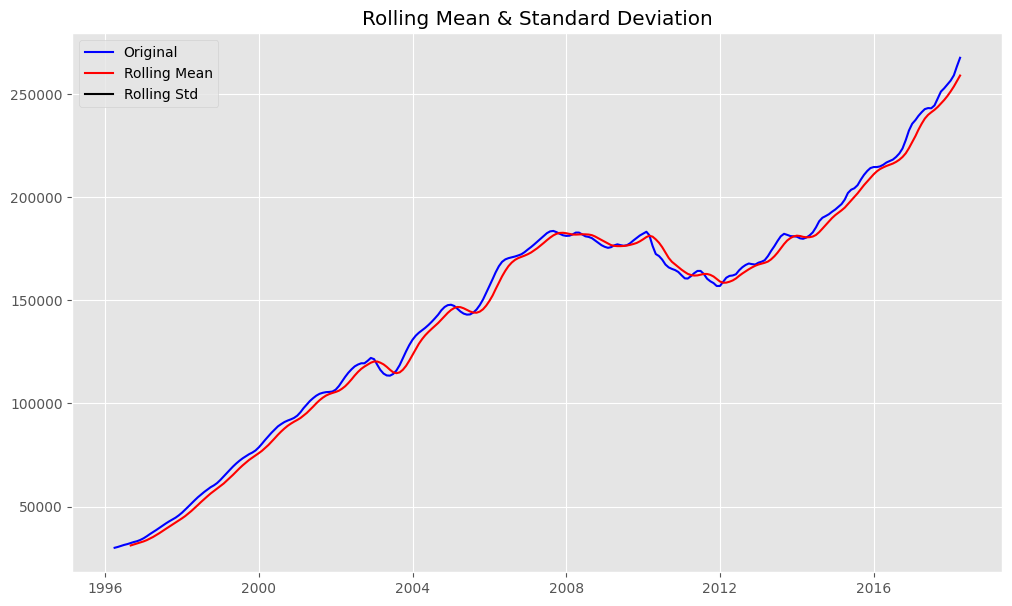

In [572]:
rolmean = series80449.rolling(window = 6, center = False).mean()
rolstd = series80449.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(series80449, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [573]:
p_val_orig = adfuller(series80449[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_orig},")
if p_val_orig < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.9503415459897898,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


In [574]:
#See what differencing does
data_diff = series80449.diff(periods=1)
data_diff.head(10)

,value
time,
1996-04-01,NaN
1996-05-01,400.0
1996-06-01,500.0
1996-07-01,500.0
1996-08-01,400.0
1996-09-01,500.0
1996-10-01,500.0
1996-11-01,400.0
1996-12-01,600.0


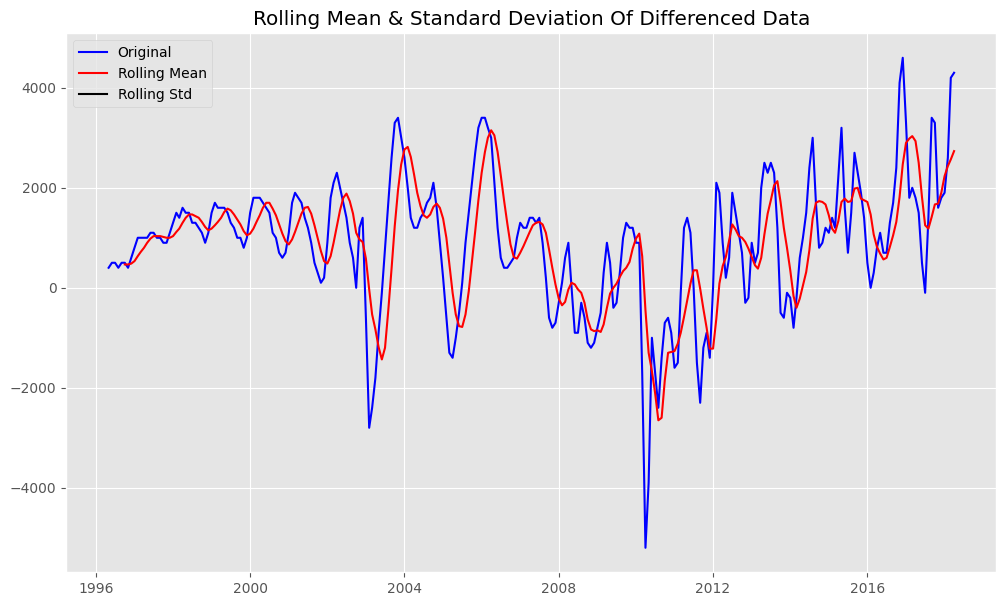

In [575]:
rolmean = data_diff.rolling(window = 6, center = False).mean()
rolstd = data_diff.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(data_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Of Differenced Data')
plt.show(block=False)

In [576]:
p_val_diff_1 = adfuller(data_diff[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_diff_1},")
if p_val_diff_1 < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.30144200668853177,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


In [577]:
def find_best_difference(data):
    for i in range(0,25):
        difference = data.diff(periods=i)
        dftest = adfuller(difference[i:])
        print(i,dftest[1])

find_best_difference(series80449)

0 nan
1 0.30144200668853177
2 0.35578029278822404
3 0.24748940108738054
4 0.3731861559286106
5 0.45246846472992297
6 0.5928948838589825
7 0.6183757128814649
8 0.6509972608489843
9 0.8112046558755531
10 0.7323846852827647
11 0.742442713548547
12 0.7042770067365571
13 0.7433009633690716
14 0.7758635692819897
15 0.5760633077144514
16 0.680523319736612
17 0.8203633371056294
18 0.7682994200552755
19 0.5219362573265781
20 0.6089457785387029
21 0.350281884227174
22 0.2363732198865896
23 0.17115845323616014
24 0.24055418744838208


Differencing doesn't seem to be making a difference. Will try logging 

In [578]:
#See what logging does
data_log = np.log(series80449)
data_log.head(10)

,value
time,
1996-04-01,10.308953
1996-05-01,10.322198
1996-06-01,10.338511
1996-07-01,10.354563
1996-08-01,10.367222
1996-09-01,10.382823
1996-10-01,10.398184
1996-11-01,10.410305
1996-12-01,10.428216


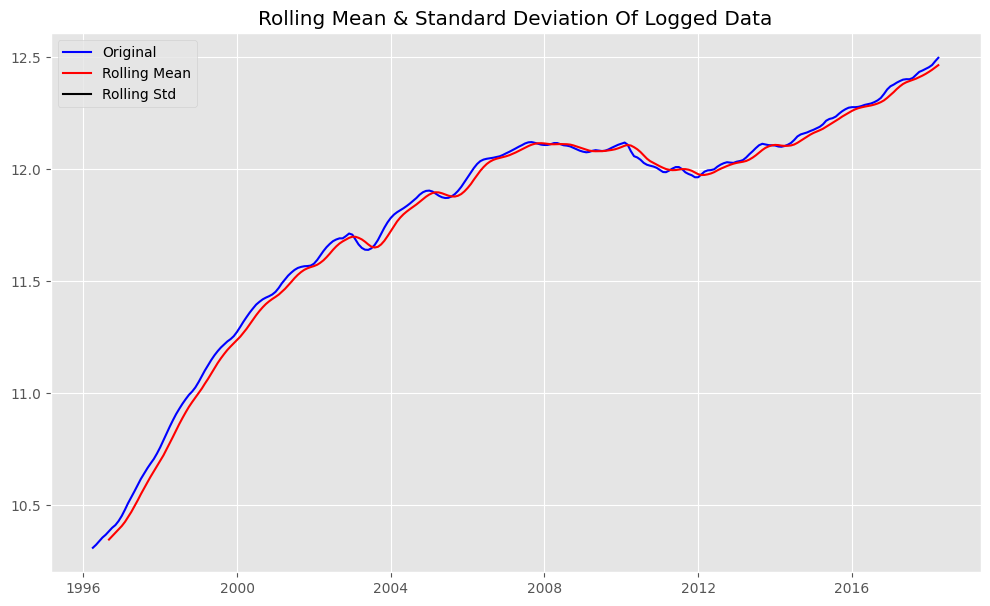

In [579]:
rolmean = data_log.rolling(window = 6, center = False).mean()
rolstd = data_log.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(data_log, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Of Logged Data')
plt.show(block=False)

## Dickey Fuller Test for Logged Data

In [580]:
p_val_log_1 = adfuller(data_log[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_log_1},")
if p_val_log_1 < 0.05:
    print(" so we can safely assume that the logged data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.023716061959590928,
 so we can safely assume that the logged data is stationary.


In [581]:
find_best_difference(data_log) # Looks like no period difference on the log is enough!

0 nan
1 0.0671671259841669
2 0.27354045146636974
3 0.21132322454530333
4 0.29148779604377606
5 0.2919789888768549
6 0.18970425389444762
7 0.23204068982754084
8 0.12264630347067285
9 0.2113076408318239
10 0.15290683650229114
11 0.1861739510624113
12 0.11118994349813566
13 0.09827910812670182
14 0.17240835343822608
15 0.13069672609641853
16 0.10786301381607705
17 0.11076514168358265
18 0.09793142529851168
19 0.23409551958882485
20 0.1066279228571772
21 0.02928769346331909
22 0.03874040702850562
23 0.11821677146103526
24 0.0903348308504352


## Dickey Fuller Test Result for Squared Data

In [582]:
p_val_sqrt = adfuller(pd.Series(np.sqrt(series80449['value']), index=series80449.index))[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_sqrt},")
if p_val_sqrt < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.458083430949465,
 so we cannot reject the null hypothesis that the differenced data is not stationary.


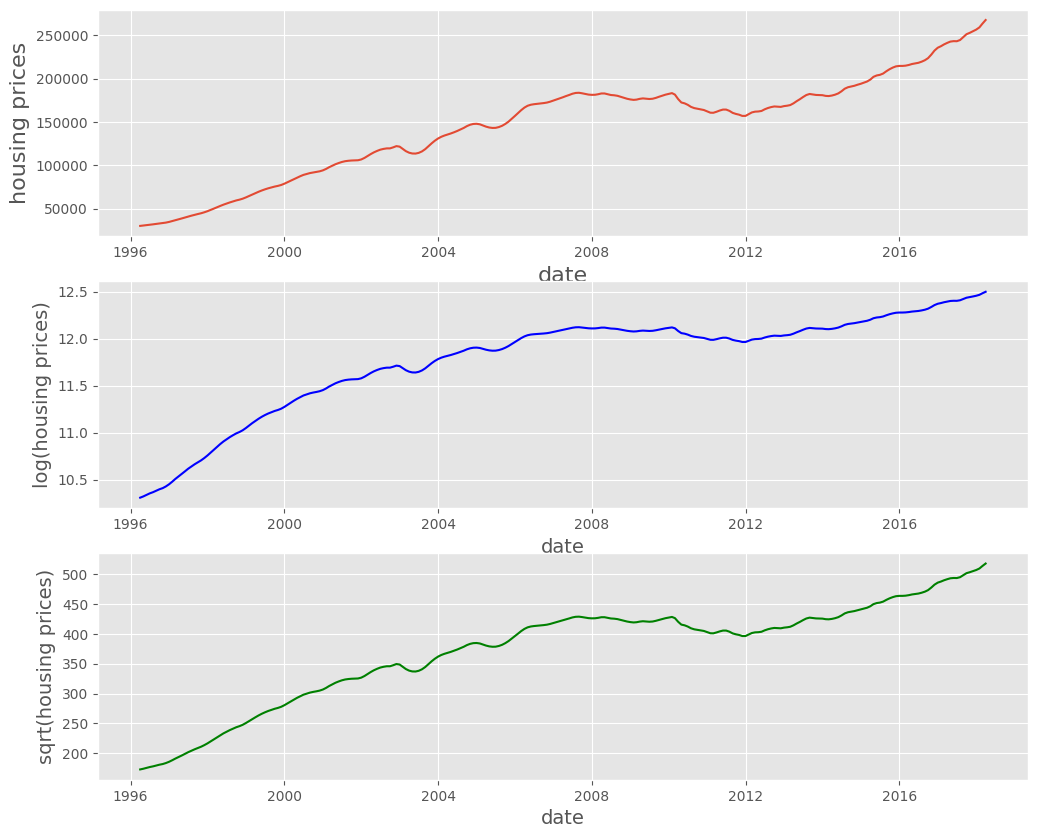

In [583]:
fig = plt.figure(figsize=(12,10))

# No transformation
plt.subplot(3, 1, 1)
plt.plot(series80449)
plt.xlabel("date", fontsize=16)
plt.ylabel("housing prices", fontsize=16)

# Log transformation (linear and heteroscedastic)
plt.subplot(3, 1, 2)
plt.plot(pd.Series(np.log(series80449['value']), index=series80449.index), color="blue")
plt.xlabel("date", fontsize=14)
plt.ylabel("log(housing prices)", fontsize=14)

# Square root transformation 
plt.subplot(3, 1, 3)
plt.plot(pd.Series(np.sqrt(series80449['value']), index=series80449.index), color="green")
plt.xlabel("date", fontsize=14)
plt.ylabel("sqrt(housing prices)", fontsize=14)


plt.show()

## Seasonal Decomposition

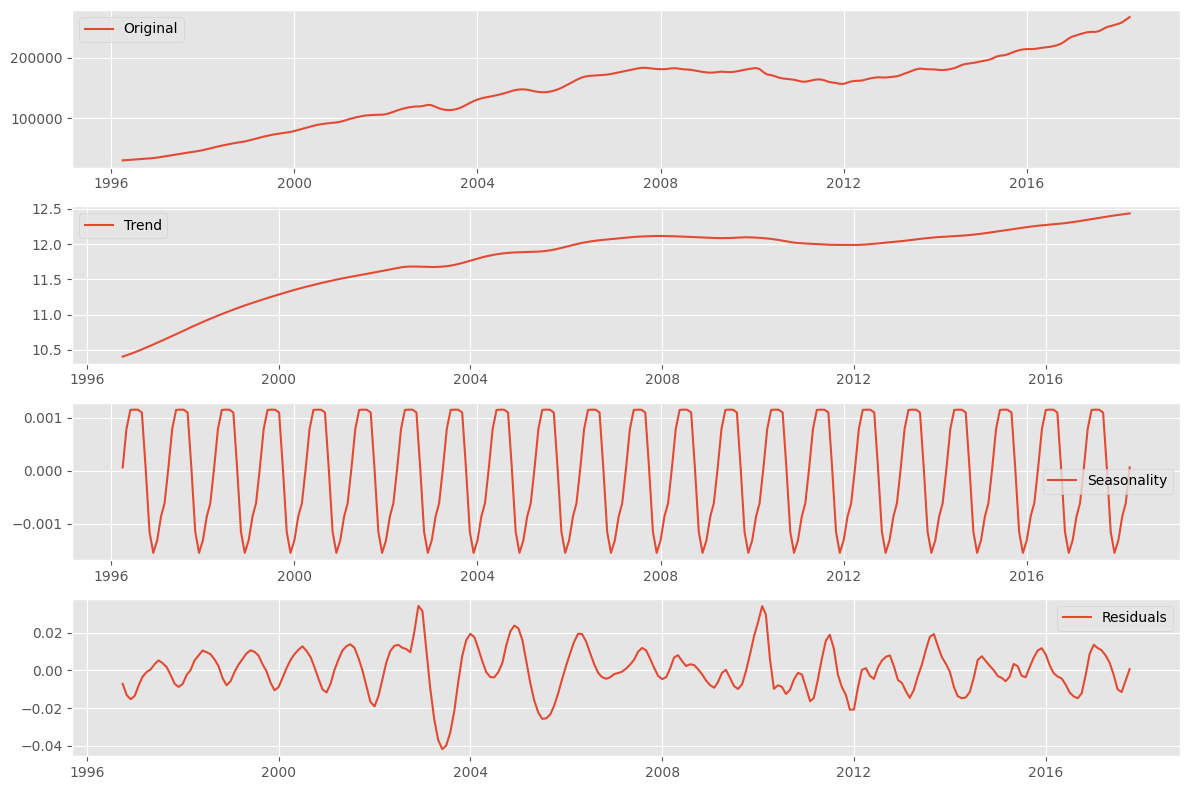

In [584]:
# Import and apply seasonal_decompose()
decomposition = seasonal_decompose(np.log(series80449))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(series80449, label='Original')#np.log(ts)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
#plt.savefig('Images/decomposition.png')
plt.tight_layout()

In [585]:
# Drop missing values from residuals 
series80449_residuals = residual
series80449_residuals.dropna(inplace=True)

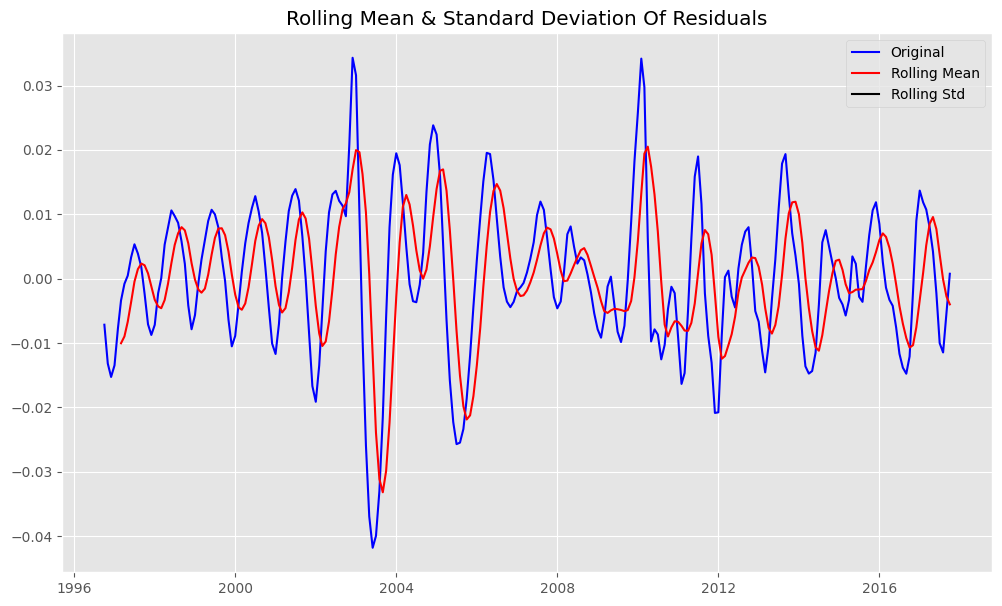

In [586]:
rolmean = series80449_residuals.rolling(window = 6, center = False).mean()
rolstd = series80449_residuals.rolling(window = 1, center = False).std()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(series80449_residuals, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Of Residuals')
plt.show(block=False)

In [587]:
p_val_resid = adfuller(series80449_residuals[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val_resid},")
if p_val_resid < 0.05:
    print(" so we can safely assume that the residual data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the residual data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 4.64926622852713e-10,
 so we can safely assume that the residual data is stationary.


## ACF and PACF

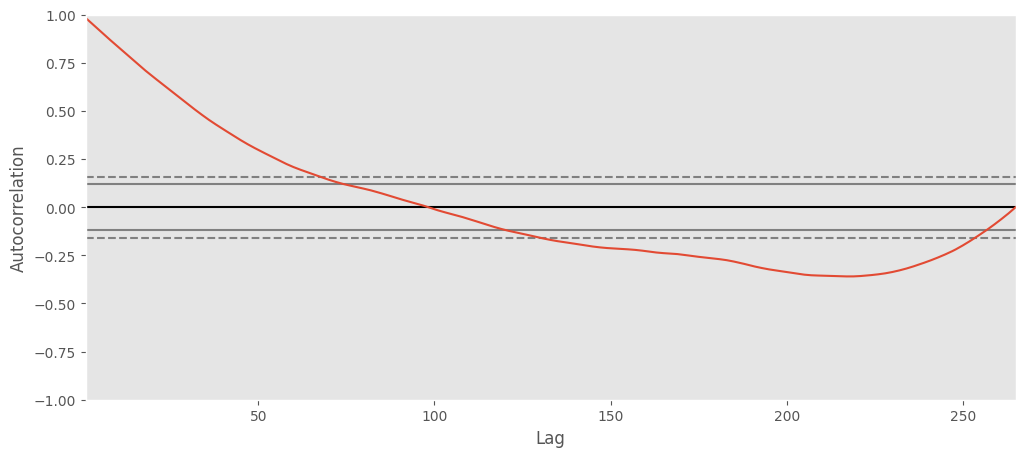

In [588]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(series80449);
# Don't see spikes for yearly correlations

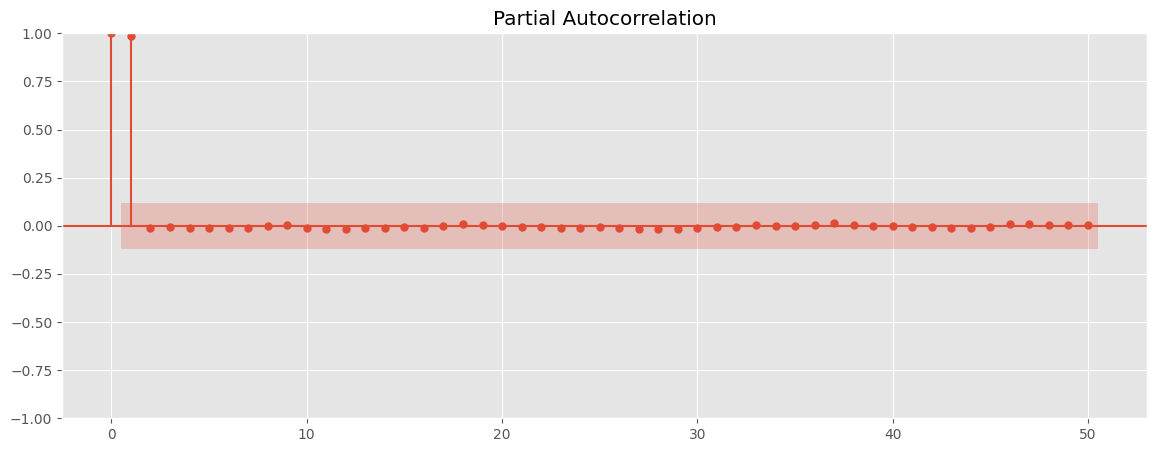

In [589]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(series80449, lags=50);

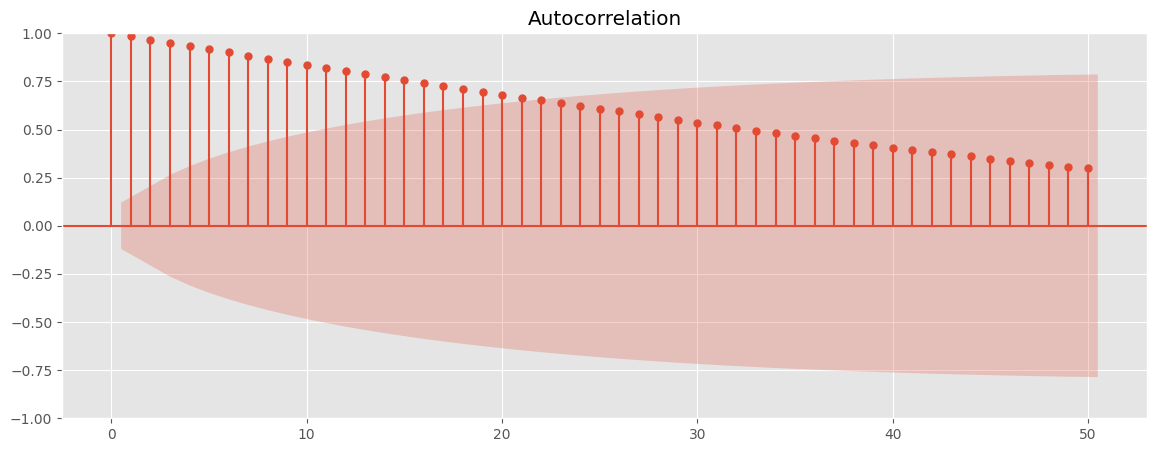

In [590]:
rcParams['figure.figsize'] = 14, 5

plot_acf(series80449, lags=50);

# Model Building

## Splitting the Data into Train and Test

In order to evaluate the accuracy of the predictions generated by the models, a train test split will be utilized. The train-test split for a time series is a little different from what we are used to. Because chronological order matters, we cannot randomly sample points in our data. Instead, we cut off a portion of our data at the end, and reserve it as our test set.

In [591]:
# find the index which allows us to split off 20% of the data
cutoff = round(series80449.shape[0]*0.8)
cutoff

212

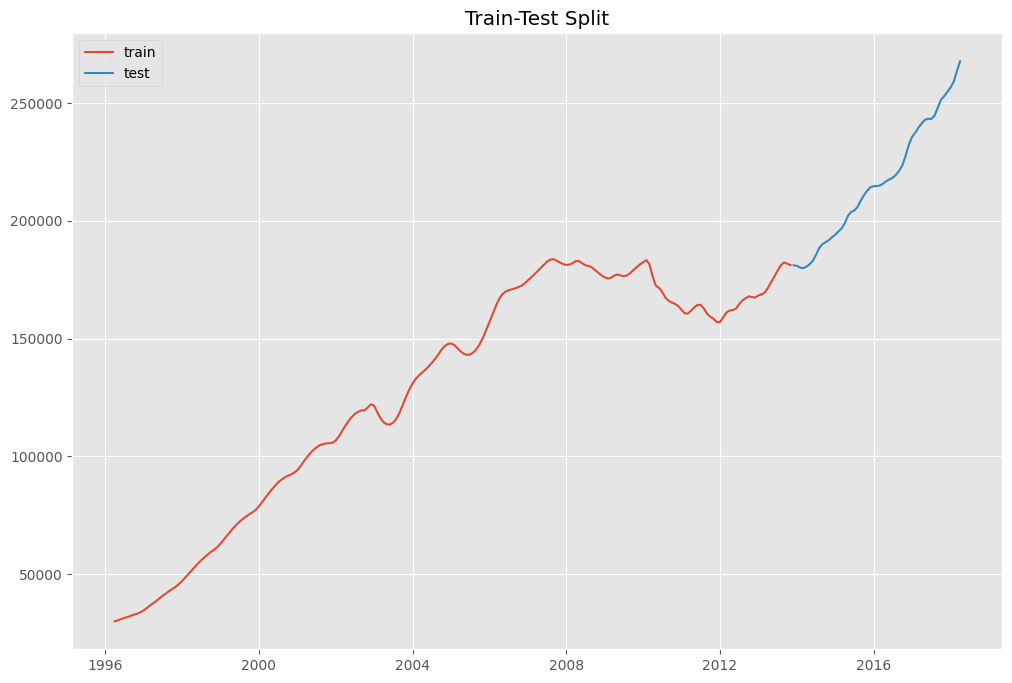

In [592]:
# Define train and test sets according to the index found above
train = series80449[:cutoff]

test = series80449[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [593]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 1

## Establishing A Baseline Naive Model

In [594]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

,value
time,
1996-04-01,NaN
1996-05-01,30000.0
1996-06-01,30400.0
1996-07-01,30900.0
1996-08-01,31400.0
...,...
2013-07-01,176300.0
2013-08-01,178800.0
2013-09-01,181100.0


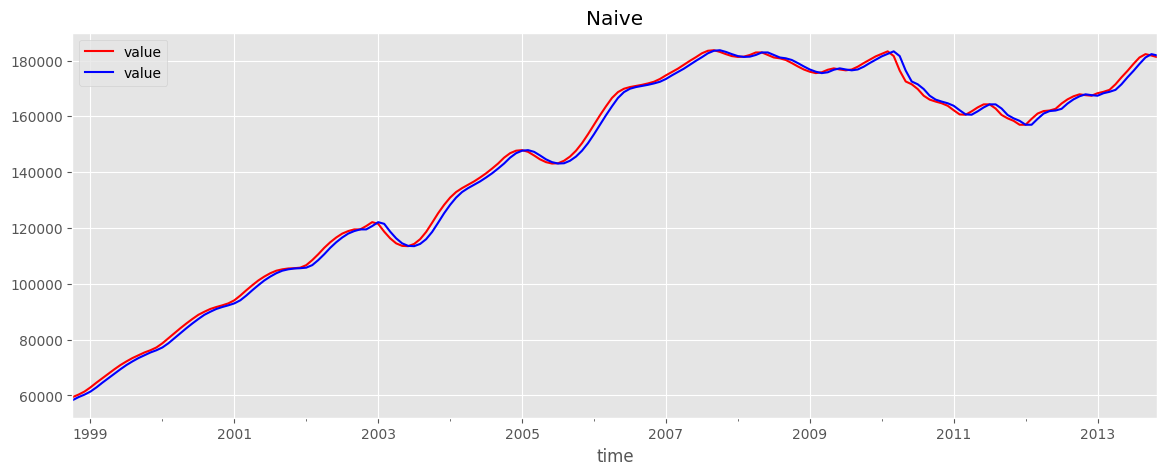

In [595]:
fig, ax = plt.subplots()

train[30:].plot(ax=ax, c='r', label='original')
naive[30:].plot(ax=ax, c='b', label='shifted')
ax.set_title('Naive')
ax.legend();

For a baseline to compare our later models, lets calculate our RMSE for the naive model.

In [596]:
naive_pred = naive.iloc[-1]
print(naive_pred)

value    181800.0
Name: 2013-11-01 00:00:00, dtype: float64


In [597]:
naive_df = test.copy()
naive_df['value'] = naive_pred['value']

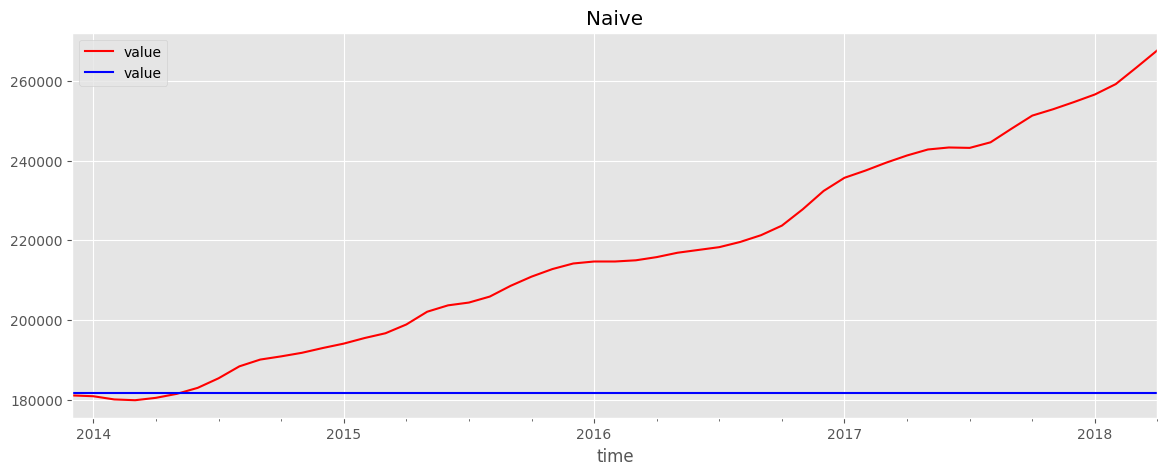

In [598]:
fig, ax = plt.subplots()

test.plot(ax=ax, c='r', label='original')
naive_df.plot(ax=ax, c='b', label='shifted')
ax.set_title('Naive')
ax.legend();

In [599]:
base_rmse = np.sqrt(mean_squared_error(test, naive_df))
print(base_rmse)

42967.06724835346


# AUTO ARIMA MODEL

## Fitting an AUTO-ARIMA Model on our Training Series


For time series modeling a stationary dataset is usually required to create an accurate prediction model. However, by utilizing an AUTO-ARIMA model, the model itself will generate the optimal values to eliminate stationarity and create predictions. As a result, in order to streamline the process of modeling a AUTO-ARIMA model will be built using the data from the zipcode. 

In [600]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [601]:
# Creating and Fitting an AUTO ARIMA model to the train dataset
import pmdarima as pm

auto_model = pm.auto_arima(train,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3271.014, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3337.315, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3316.072, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3291.124, Time=0.34 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3269.592, Time=0.36 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3290.454, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3291.532, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=3270.824, Time=1.05 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=3282.339, Time=0.72 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3286.798, Time=0.36 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=3266.534, Time=1.99 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=3265.016, Time=2.40 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=3272.341, Time=1.46 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=3265.325, Time=1.89 sec
 ARIMA(3,2,4)(0,0,0)[0]          

In [602]:
#Identifying the order values for the model
auto_model.order

(4, 2, 4)

In [603]:
#Identifying the Seasonal Order values for the model
auto_model.seasonal_order

(0, 0, 0, 0)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6642      0.387      1.718      0.086      -0.094       1.422
ar.L2          0.1339      0.130      1.033      0.301      -0.120       0.388
ar.L3          0.0875      0.126      0.695      0.487      -0.159       0.334
ar.L4         -0.1985      0.086     -2.312      0.021      -0.367      -0.030
ma.L1          0.0596      0.394      0.151      0.880      -0.712       0.832
ma.L2         -0.9767      0.241     -4.047      0.000      -1.450      -0.504
ma.L3         -0.4658      0.272     -1.715      0.086      -0.998       0.067
ma.L4          0.4403      0.320      1.377      0.169      -0.186       1.067
sigma2      2.283e+05   1.29e+04     17.743      0.000    2.03e+05    2.54e+05


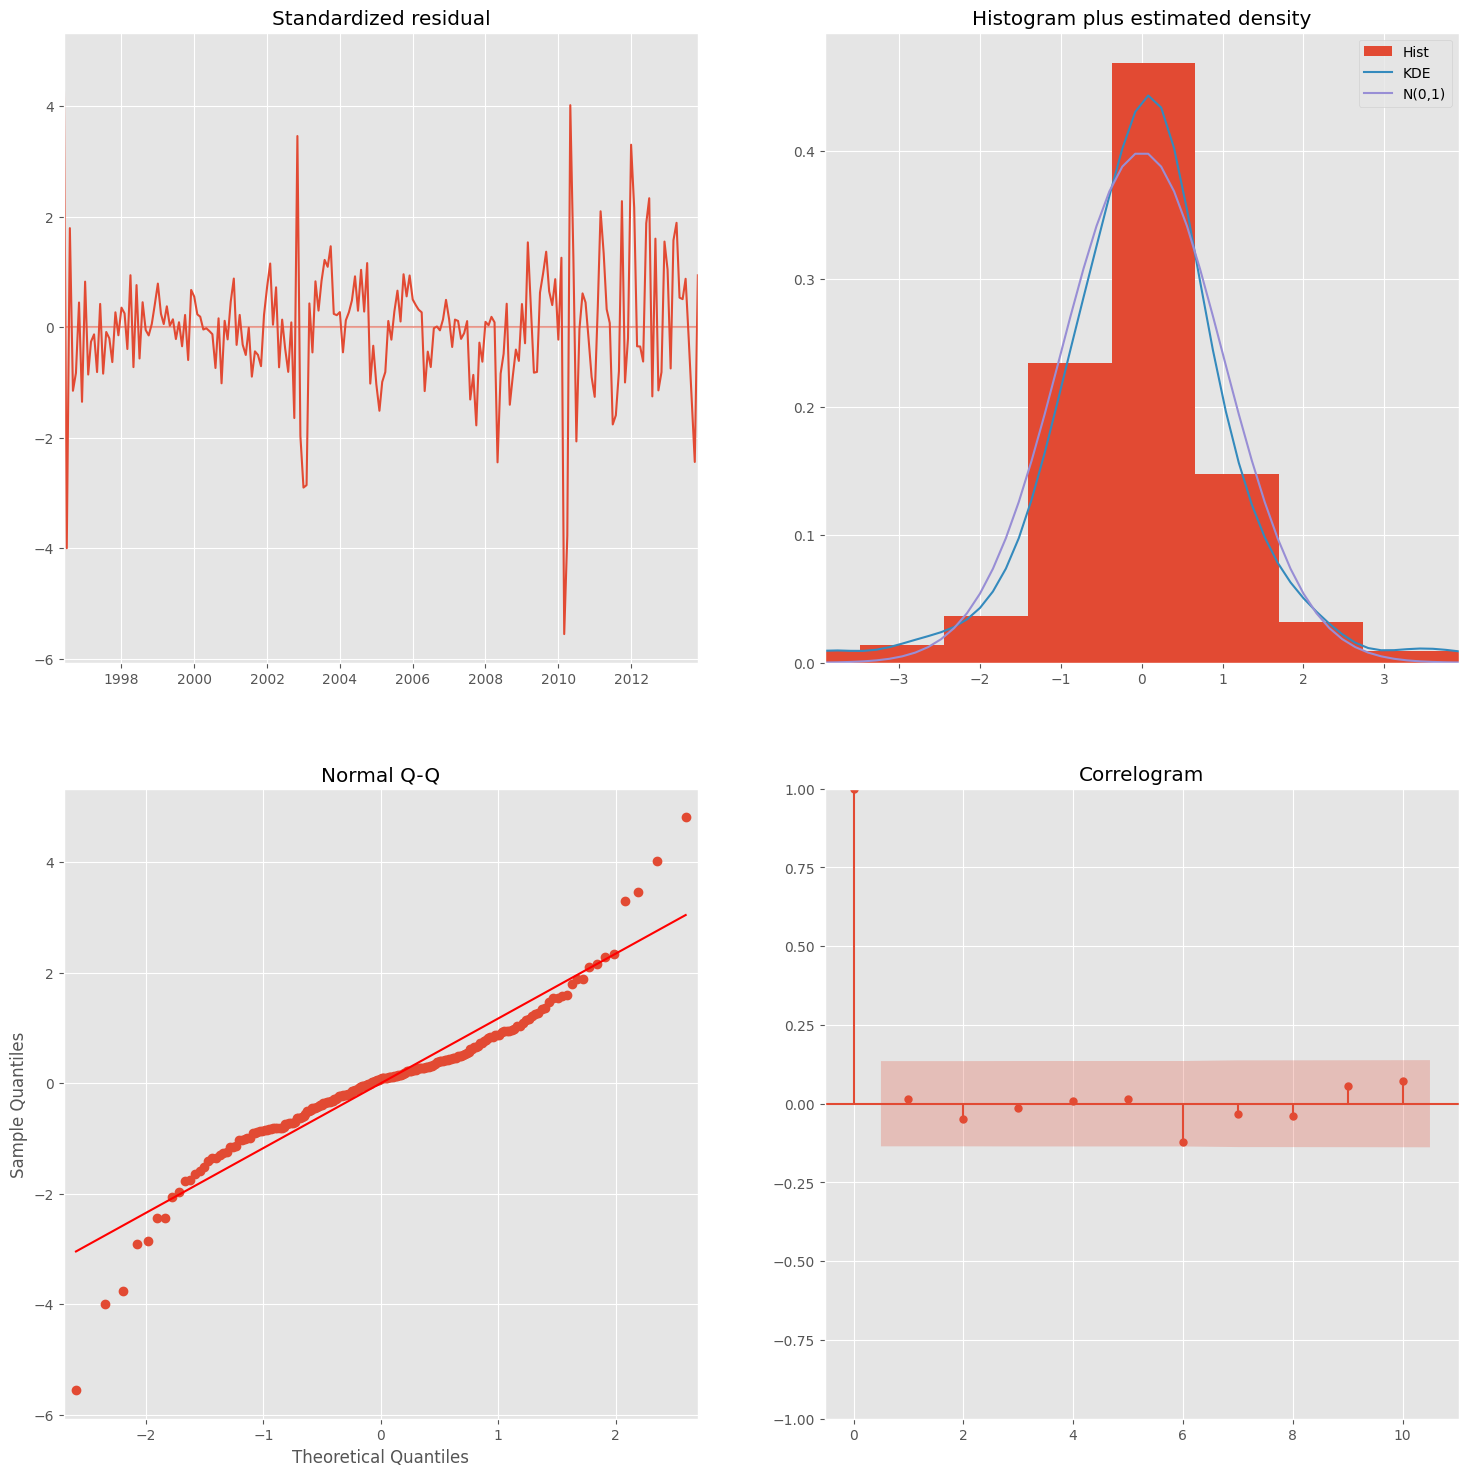

In [604]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(4,2,4), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

It is important to confirm that the residuals are not correlated and that they are normally distributed. Otherwise, additional changes will need to be made to the model. 

Checking each of the diagnostic plots:

- In the plot on the top right, the KDE line somewhat closely follows along the N(0,1) line which is the standard notation for a normal distribution having a mean of 0 and a standard deviation of 1. As a result, this can be interpreted to mean that the residuals are normally distributed. 

- The qq-plot shwon on the bottom left displays that the residuals follow the linear trend line. As a result, it can also be interpreted to mean that the residuals are normally distributed. 

- From the Correlogram plot on the bottom left, it can be seen that the time series residuals displace low correlation with their lagged versions. This becomes clearer as the time series continues further along. This seems to indicate that there isn't any obvious seasonality in our series. 

Based on these observations, it can be confidently concluded that the model does not have correlations and that it satisfactorily fits the data to forecast future prices. 

In [605]:
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  212
Model:               SARIMAX(4, 2, 4)   Log Likelihood               -1556.942
Date:                Wed, 07 Jun 2023   AIC                           3131.883
Time:                        03:51:43   BIC                           3161.790
Sample:                    04-01-1996   HQIC                          3143.980
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6642      0.387      1.718      0.086      -0.094       1.422
ar.L2          0.1339      0.130      1.033      0.301      -0.120       0.388
ar.L3          0.0875      0.126      0.695      0.487      -0.159       0.334
ar.L4         -0.1985      0.086     -2.312      0.021      -0.367      -0.030
ma.L1          0.0596      0.394      0.151      0.880      -0.712       0.832
ma.L2         -0.9767      0.241     -4.047      0.000      -1.450      -0.504
ma.L3         -0.4658      0.272     -1.715      0.086      -0.998       0.067
ma.L4          0.4403      0.320      1.377      0.169      -0.186       1.067
sigma2      2.283e+05   1.29e+04     17.743      0.000    2.03e+05    2.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               397.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               9.08   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluating the ARIMA Model Performance

In order to test the accuracy of the model, the predictions for the period between May 2013 and April 2018 will be retrieved. The predictions will be plotted on the same chart to see how far and/or close they are.

In [606]:
# Get predictions starting from 04-01-2015 and calculate confidence intervals
pred_arima = output.get_prediction(start=pd.to_datetime('2013-12'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf_arima = pred_arima.conf_int()

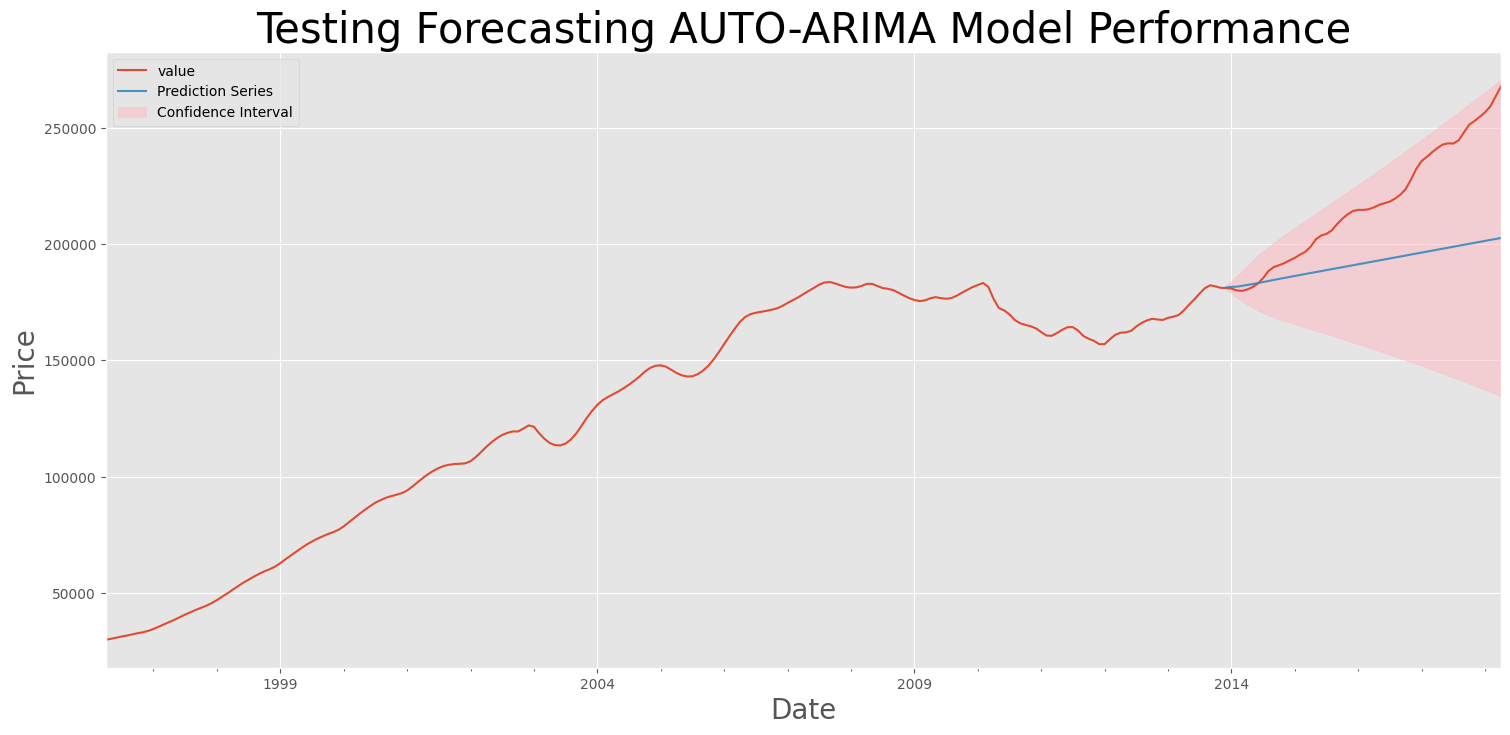

In [607]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = series80449.plot(label='observed')

# Plot predicted values
pred_arima.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf_arima.index,
                pred_conf_arima.iloc[:, 0],
                pred_conf_arima.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting AUTO-ARIMA Model Performance',fontsize=30)
plt.legend()

plt.show()

In [608]:
# Get the real and predicted values
price_forecasted = pred_arima.predicted_mean
price_truth = series80449['2013-12-01':]

# Compute the mean square error
arima_rmse = np.sqrt(mean_squared_error(price_forecasted, price_truth))
print(arima_rmse)

31204.69249024491


In [609]:
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
if arima_rmse < base_rmse:
    print("Based on RMSE value the AUTO ARIMA model has outperformed the Baseline Model")
else:
    print(f"Based on RMSE value the AUTO ARIMA model has been outperformed by the Baseline Model with a RMSE of {base_rmse}")

The RMSE value associated with the AUTO ARIMA model is 31204.69249024491.
Based on RMSE value the AUTO ARIMA model has outperformed the Baseline Model


# Facebook Prophet Model

## Fitting an Facebook Prophet Model on the Training Series¶

In [610]:
train

,value
time,
1996-04-01,30000.0
1996-05-01,30400.0
1996-06-01,30900.0
1996-07-01,31400.0
1996-08-01,31800.0
...,...
2013-07-01,178800.0
2013-08-01,181100.0
2013-09-01,182300.0


In [611]:
fb_train = pd.Series(np.log(train['value']), index=train.index)
fb_train = fb_train.reset_index()

In [612]:
fb_train

,time,value
0,1996-04-01,10.308953
1,1996-05-01,10.322198
2,1996-06-01,10.338511
3,1996-07-01,10.354563
4,1996-08-01,10.367222
...,...,...
207,2013-07-01,12.094023
208,2013-08-01,12.106805
209,2013-09-01,12.113409
210,2013-10-01,12.110662


In [613]:
fb_train = fb_train.rename(columns={'value': 'y', 'time': 'ds'})
fb_train.head(5)

,ds,y
0,1996-04-01,10.308953
1,1996-05-01,10.322198
2,1996-06-01,10.338511
3,1996-07-01,10.354563
4,1996-08-01,10.367222


In [614]:
FB_Model = Prophet()

FB_Model.fit(fb_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jipy6mg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/zluu9n3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19117', 'data', 'file=/tmp/tmpqnwsa2__/jipy6mg9.json', 'init=/tmp/tmpqnwsa2__/zluu9n3k.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelv7_runfc/prophet_model-20230607035144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [615]:
fb_future_dates = FB_Model.make_future_dataframe(periods=53, freq='MS')
fb_future_dates.tail()

,ds
260,2017-12-01
261,2018-01-01
262,2018-02-01
263,2018-03-01
264,2018-04-01


In [616]:
fb_forecast = FB_Model.predict(fb_future_dates)
fb_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1996-04-01,10.292246,10.266628,10.322743,10.292246,10.292246,0.003371,0.003371,0.003371,0.003371,0.003371,0.003371,0.0,0.0,0.0,10.295617
1,1996-05-01,10.309754,10.285764,10.344068,10.309754,10.309754,0.004248,0.004248,0.004248,0.004248,0.004248,0.004248,0.0,0.0,0.0,10.314002
2,1996-06-01,10.327846,10.303237,10.361165,10.327846,10.327846,0.003787,0.003787,0.003787,0.003787,0.003787,0.003787,0.0,0.0,0.0,10.331633
3,1996-07-01,10.345355,10.321137,10.377367,10.345355,10.345355,0.003942,0.003942,0.003942,0.003942,0.003942,0.003942,0.0,0.0,0.0,10.349297
4,1996-08-01,10.363447,10.338791,10.396499,10.363447,10.363447,0.003801,0.003801,0.003801,0.003801,0.003801,0.003801,0.0,0.0,0.0,10.367248


In [617]:
fb_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2017-12-01,12.072566,11.496100,12.556844
261,2018-01-01,12.073967,11.494591,12.580977
262,2018-02-01,12.076418,11.478101,12.596358
263,2018-03-01,12.079968,11.435383,12.619486
264,2018-04-01,12.080966,11.436437,12.630223


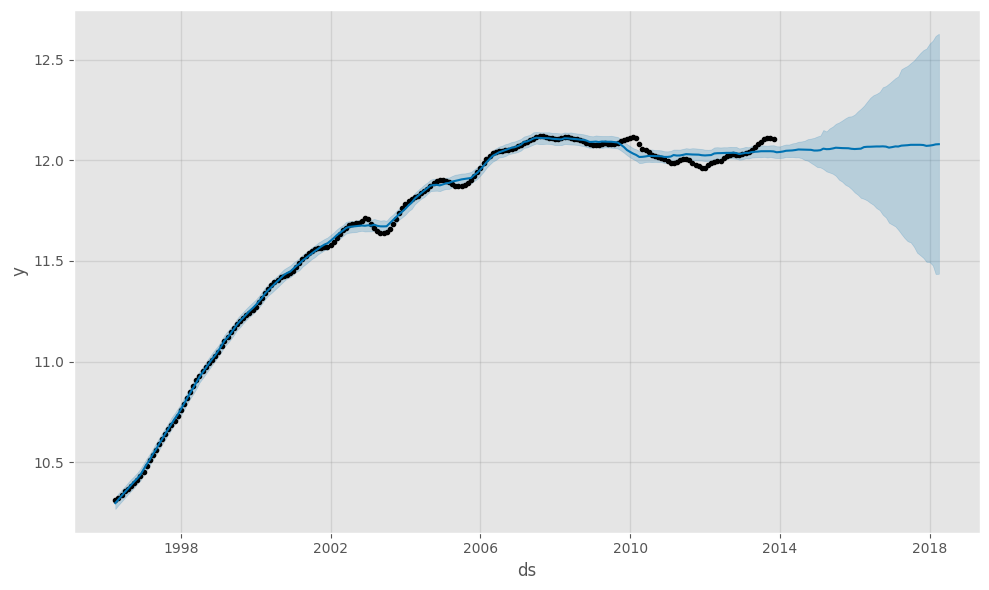

In [618]:
FB_Model.plot(fb_forecast)
plt.show();

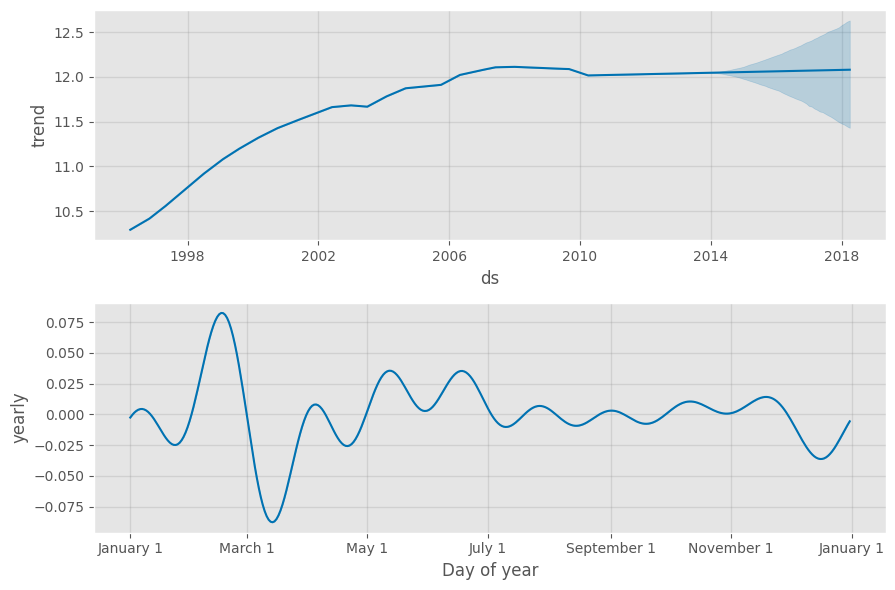

In [619]:
FB_Model.plot_components(fb_forecast)
plt.show();

In [620]:
fb_test = pd.Series(np.log(test['value']), index=test.index)
fb_test = fb_test.reset_index()

In [621]:
fb_test = fb_test.rename(columns={'value': 'y', 'time': 'ds'})
fb_test.head(5)

,ds,y
0,2013-12-01,12.106805
1,2014-01-01,12.105700
2,2014-02-01,12.101268
3,2014-03-01,12.100156
4,2014-04-01,12.103486


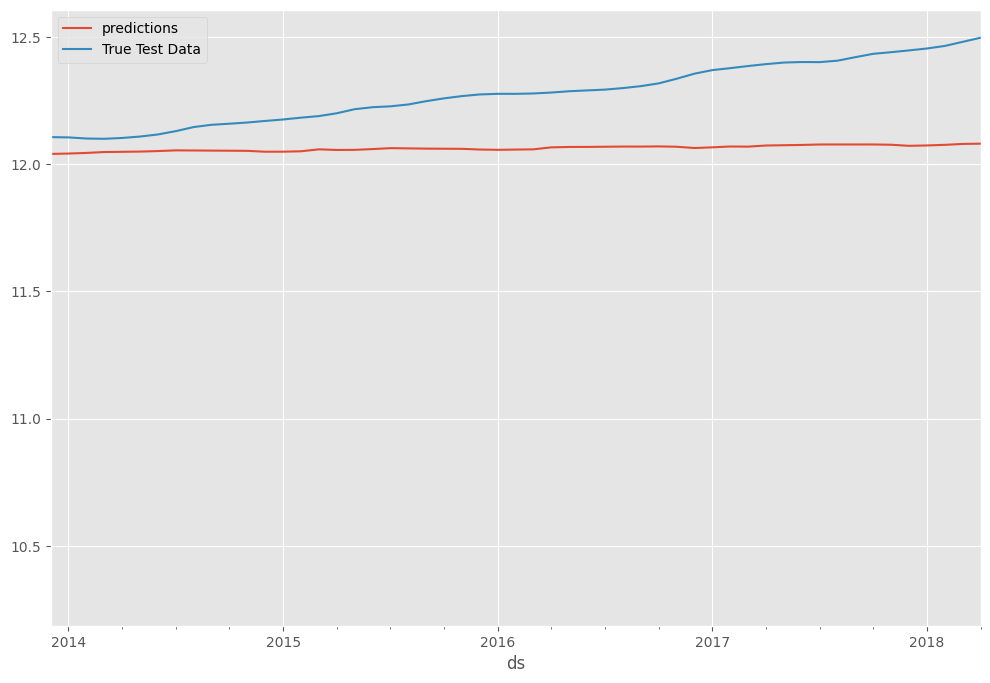

In [622]:
ax=fb_forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
fb_test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2013-12-01','2018-04-01'));

## Evaluating the Facebook Prophet Model

In [623]:
fb_forecast[212:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
212,2013-12-01,12.044627,12.012138,12.070712,12.044627,12.044627,-0.003880,-0.003880,-0.003880,-0.003880,-0.003880,-0.003880,0.0,0.0,0.0,12.040746
213,2014-01-01,12.045302,12.012396,12.069789,12.045006,12.045386,-0.003154,-0.003154,-0.003154,-0.003154,-0.003154,-0.003154,0.0,0.0,0.0,12.042147
214,2014-02-01,12.045977,12.013653,12.075621,12.043681,12.048272,-0.001378,-0.001378,-0.001378,-0.001378,-0.001378,-0.001378,0.0,0.0,0.0,12.044599
215,2014-03-01,12.046587,12.017454,12.079495,12.041477,12.051567,0.001562,0.001562,0.001562,0.001562,0.001562,0.001562,0.0,0.0,0.0,12.048148
216,2014-04-01,12.047262,12.016500,12.079181,12.038518,12.055366,0.001885,0.001885,0.001885,0.001885,0.001885,0.001885,0.0,0.0,0.0,12.049146
217,2014-05-01,12.047915,12.017160,12.084691,12.035551,12.060796,0.001991,0.001991,0.001991,0.001991,0.001991,0.001991,0.0,0.0,0.0,12.049906
218,2014-06-01,12.048590,12.015286,12.087516,12.029170,12.066466,0.003350,0.003350,0.003350,0.003350,0.003350,0.003350,0.0,0.0,0.0,12.051940
219,2014-07-01,12.049244,12.015475,12.093040,12.022883,12.072236,0.005443,0.005443,0.005443,0.005443,0.005443,0.005443,0.0,0.0,0.0,12.054687
220,2014-08-01,12.049919,12.011629,12.094630,12.017282,12.077543,0.004330,0.004330,0.004330,0.004330,0.004330,0.004330,0.0,0.0,0.0,12.054249
221,2014-09-01,12.050594,12.002479,12.098591,12.010693,12.084471,0.003015,0.003015,0.003015,0.003015,0.003015,0.003015,0.0,0.0,0.0,12.053609


In [624]:
# Get the real and predicted values
fb_prediction = fb_forecast[212:]
fb_prediction = fb_prediction[['yhat','ds']]
fb_prediction['unlog_value'] = np.exp(fb_prediction['yhat'])

In [625]:
# Compute the mean square error
fb_rmse = np.sqrt(mean_squared_error(test['value'], fb_prediction['unlog_value']))
print(fb_rmse)

49199.202762526045


In [626]:
print(f"The RMSE value associated with the base model is {base_rmse}.")
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
print(f"The RMSE value associated with the Facebook Prophet model is {fb_rmse}.")

The RMSE value associated with the base model is 42967.06724835346.
The RMSE value associated with the AUTO ARIMA model is 31204.69249024491.
The RMSE value associated with the Facebook Prophet model is 49199.202762526045.


## Tuning the Facebook Prophet Model

We can see from the above plot, that there is huge gap in prediction. So we need to optimize the model by adding other parameters like holidays, changepoints etc.

## Importing Holidays into the Facebook Model

In [627]:
test

,value
time,
2013-12-01,181100.0
2014-01-01,180900.0
2014-02-01,180100.0
2014-03-01,179900.0
2014-04-01,180500.0
2014-05-01,181500.0
2014-06-01,183000.0
2014-07-01,185400.0
2014-08-01,188400.0


In [628]:
year_list = [1996, 1997,1998,1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 
            2013, 2014, 2015, 2016, 2017, 2018]

In [629]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=year_list).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [630]:
holiday.head()

,ds,holiday
0,1996-01-01,US-Holidays
1,1996-01-15,US-Holidays
2,1996-02-19,US-Holidays
3,1996-05-27,US-Holidays
4,1996-07-04,US-Holidays


In [631]:
fb_model_with_holidays = Prophet(holidays=holiday)
fb_model_with_holidays.fit(fb_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/rn2vq0_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/nbdp23bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80449', 'data', 'file=/tmp/tmpqnwsa2__/rn2vq0_7.json', 'init=/tmp/tmpqnwsa2__/nbdp23bq.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelfzmc7f3i/prophet_model-20230607035148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [632]:
future_with_holidays = fb_model_with_holidays.make_future_dataframe(periods=57, freq='D')
forecast_with_holidays = fb_model_with_holidays.predict(future_with_holidays)
forecast_with_holidays[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
262,2013-12-22,12.019423,11.987509,12.047735
263,2013-12-23,12.022333,11.989825,12.050706
264,2013-12-24,12.025494,11.996871,12.053522
265,2013-12-25,12.019137,11.988530,12.047181
266,2013-12-26,12.032322,12.004601,12.062349
267,2013-12-27,12.035851,12.007383,12.065403
268,2013-12-28,12.039360,12.011119,12.068720


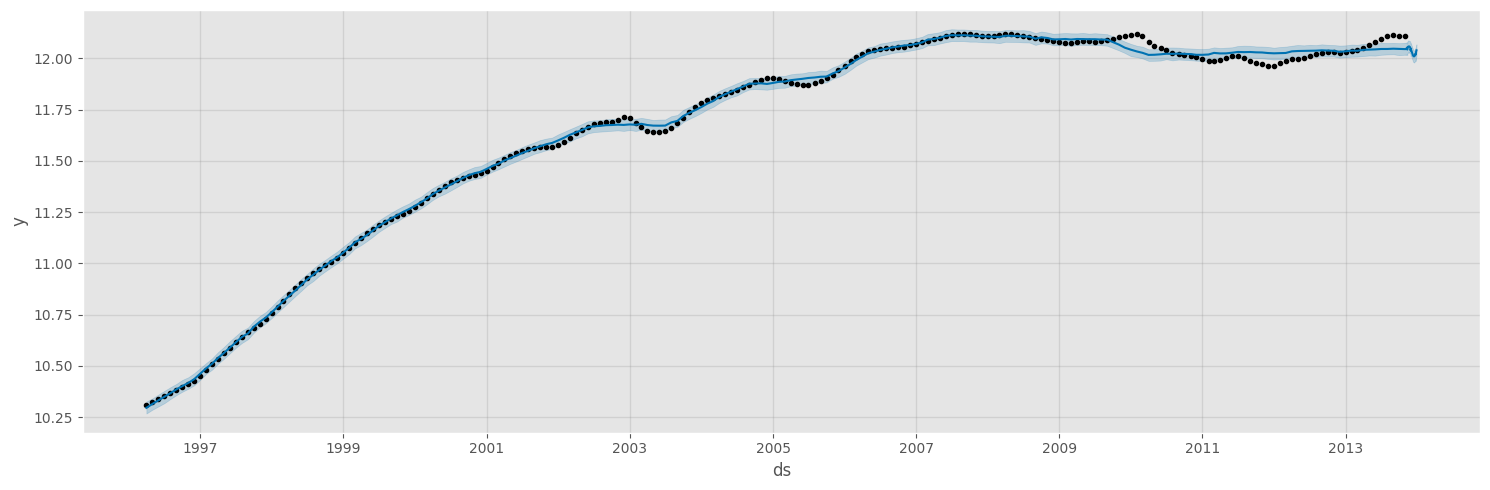

In [633]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = fb_model_with_holidays.plot(forecast_with_holidays,ax=ax)
plt.show()

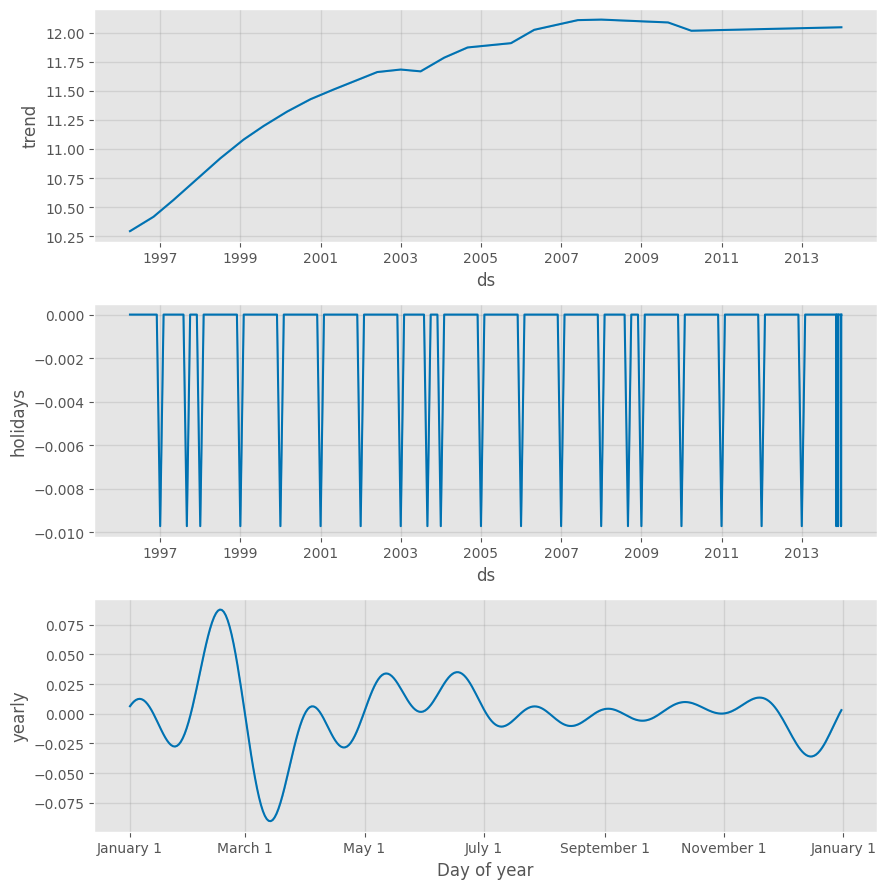

In [634]:
# Plot the components of the model
fig = fb_model_with_holidays.plot_components(forecast_with_holidays)

In [635]:
tst_forecast_holiday = fb_model_with_holidays.predict(fb_test)
tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
46,2017-10-01,12.077960,11.585094,12.631341
47,2017-11-01,12.076842,11.572776,12.632130
48,2017-12-01,12.072572,11.557529,12.654235
49,2018-01-01,12.073917,11.543325,12.675387
50,2018-02-01,12.076337,11.521462,12.692114
51,2018-03-01,12.079889,11.507072,12.705993
52,2018-04-01,12.080815,11.490402,12.728743


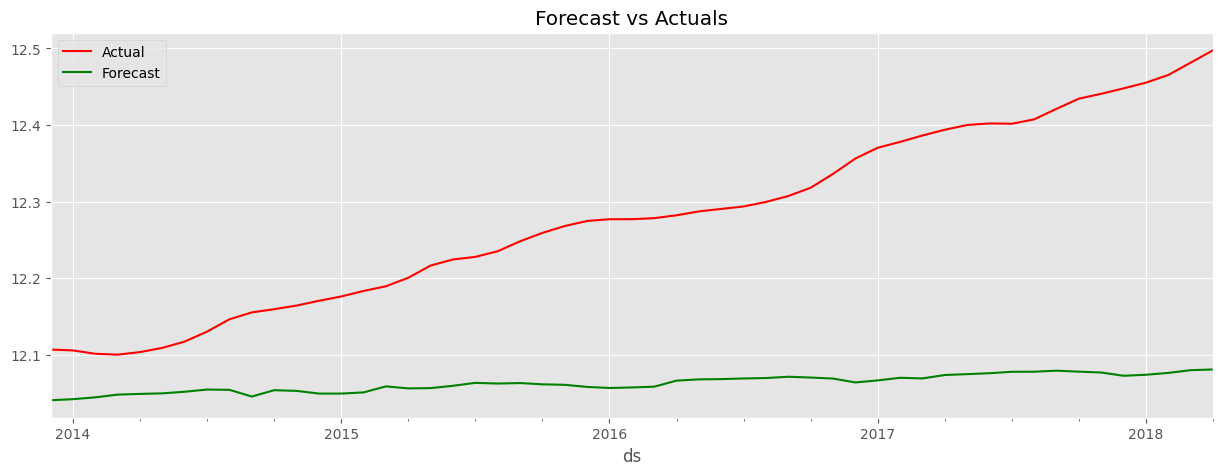

In [636]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
fb_test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
tst_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [637]:
# Get the real and predicted values
fb_holiday_prediction = tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fb_holiday_prediction = fb_holiday_prediction[['yhat','ds']]
fb_holiday_prediction['unlog_value'] = np.exp(fb_holiday_prediction['yhat'])

In [638]:
fb_holiday_rmse = np.sqrt(mean_squared_error(test['value'], fb_prediction['unlog_value']))
print(fb_holiday_rmse)

49199.202762526045


## Parameter Tuning for the Facebook Prophet Model

In [639]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [640]:
fb_holiday_prediction = tst_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fb_holiday_prediction = fb_holiday_prediction[['yhat','ds']]
fb_holiday_prediction['unlog_value'] = np.exp(fb_holiday_prediction['yhat'])

fb_holiday_rmse = np.sqrt(mean_squared_error(test['value'], fb_prediction['unlog_value']))

In [641]:
strt='2019-12-31'
end='2020-02-26'
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
for p in grid:
    par_test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(fb_train)
    train_forecast = train_model.make_future_dataframe(periods=53, freq='M',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    par_test=train_forecast[['ds','yhat']]
    #Actual = test[(fb_test['ds']>strt) & (fb_test['ds']<=end)]
    par_test['unlog_value'] = np.exp(par_test['yhat'])
    RMSE = np.sqrt(mean_squared_error(test['value'], par_test['unlog_value']))
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/hci5wkar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/dhz5h6qs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29605', 'data', 'file=/tmp/tmpqnwsa2__/hci5wkar.json', 'init=/tmp/tmpqnwsa2__/dhz5h6qs.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modeldc7camsw/prophet_model-20230607035157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:51:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42310.49083950662
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/gg32fqr0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/r8cl8278.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3894', 'data', 'file=/tmp/tmpqnwsa2__/gg32fqr0.json', 'init=/tmp/tmpqnwsa2__/r8cl8278.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelii5vnul5/prophet_model-20230607035159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/vv3inswt.json


Root Mean Square Error(RMSE)------------------------------------ 107334.50857402135
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/fqrkdie5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18265', 'data', 'file=/tmp/tmpqnwsa2__/vv3inswt.json', 'init=/tmp/tmpqnwsa2__/fqrkdie5.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelyrigl8zt/prophet_model-20230607035202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 42889.53095966169
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/4z4meih5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/dsg_67f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8292', 'data', 'file=/tmp/tmpqnwsa2__/4z4meih5.json', 'init=/tmp/tmpqnwsa2__/dsg_67f8.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_3b1lggd/prophet_model-20230607035208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 92753.68386437216
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/nvg0zewl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/sharh495.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1996', 'data', 'file=/tmp/tmpqnwsa2__/nvg0zewl.json', 'init=/tmp/tmpqnwsa2__/sharh495.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelmsrucn6p/prophet_model-20230607035212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 43193.15158324736
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/144xhg0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/nnucx2sz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5558', 'data', 'file=/tmp/tmpqnwsa2__/144xhg0r.json', 'init=/tmp/tmpqnwsa2__/nnucx2sz.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model5_9cz3zr/prophet_model-20230607035216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 95895.35324343985
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/l0n38h39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/1obdw534.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85829', 'data', 'file=/tmp/tmpqnwsa2__/l0n38h39.json', 'init=/tmp/tmpqnwsa2__/1obdw534.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model0vj6k8d4/prophet_model-20230607035220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 48118.011998996
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ibrrqp7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/fherivjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64210', 'data', 'file=/tmp/tmpqnwsa2__/ibrrqp7z.json', 'init=/tmp/tmpqnwsa2__/fherivjt.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model0bs18lay/prophet_model-20230607035225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 380574.415529219
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/wlzcl793.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/iiygu84w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58950', 'data', 'file=/tmp/tmpqnwsa2__/wlzcl793.json', 'init=/tmp/tmpqnwsa2__/iiygu84w.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model54mfba96/prophet_model-20230607035228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 49105.13852029018
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6cd5ik22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/xxw95xqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18639', 'data', 'file=/tmp/tmpqnwsa2__/6cd5ik22.json', 'init=/tmp/tmpqnwsa2__/xxw95xqy.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelvjbkbyqx/prophet_model-20230607035231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/zs62uqyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/0umxsg_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

Root Mean Square Error(RMSE)------------------------------------ 280289.3727956326
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/aynusmma.json


Root Mean Square Error(RMSE)------------------------------------ 47169.58261573865
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/fr6lvesm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64315', 'data', 'file=/tmp/tmpqnwsa2__/aynusmma.json', 'init=/tmp/tmpqnwsa2__/fr6lvesm.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model092i6x5x/prophet_model-20230607035236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/22a7tgz9.json


Root Mean Square Error(RMSE)------------------------------------ 210948.08627416537
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/_asnn6op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87968', 'data', 'file=/tmp/tmpqnwsa2__/22a7tgz9.json', 'init=/tmp/tmpqnwsa2__/_asnn6op.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model820wz5_t/prophet_model-20230607035239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/_vi3lf17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/glwovu7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 50329.38805609131
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6ihgrbs_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/lr2xo7g9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95574', 'data', 'file=/tmp/tmpqnwsa2__/6ihgrbs_.json', 'init=/tmp/tmpqnwsa2__/lr2xo7g9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelp_hnz_dh/prophet_model-20230607035242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 669739.7072275553
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/dnsaqvs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/o0qrr4bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31541', 'data', 'file=/tmp/tmpqnwsa2__/dnsaqvs3.json', 'init=/tmp/tmpqnwsa2__/o0qrr4bo.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model7u1sijyc/prophet_model-20230607035243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 48684.392666543674
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:52:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/be4arcbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/v_dcnmer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47242', 'data', 'file=/tmp/tmpqnwsa2__/be4arcbe.json', 'init=/tmp/tmpqnwsa2__/v_dcnmer.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model5jpqr4h7/prophet_model-20230607035245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 298532.045434962
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/q0h82krk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7ghwfdvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94658', 'data', 'file=/tmp/tmpqnwsa2__/q0h82krk.json', 'init=/tmp/tmpqnwsa2__/7ghwfdvk.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model8789q6zi/prophet_model-20230607035247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 49903.52951111082
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:52:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/srvfw3os.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/f58yl0fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32076', 'data', 'file=/tmp/tmpqnwsa2__/srvfw3os.json', 'init=/tmp/tmpqnwsa2__/f58yl0fo.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model2tlqzz31/prophet_model-20230607035249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 284767.01222145604
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:52:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/nqk2r1qh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/k_bl19y9.json
DEBUG:cmdstanpy:idx 0


Root Mean Square Error(RMSE)------------------------------------ 52805.03623192151
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89317', 'data', 'file=/tmp/tmpqnwsa2__/nqk2r1qh.json', 'init=/tmp/tmpqnwsa2__/k_bl19y9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model09ml92pt/prophet_model-20230607035250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/sz8drhja.json


Root Mean Square Error(RMSE)------------------------------------ 533053.6494638742
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/refs9mwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5338', 'data', 'file=/tmp/tmpqnwsa2__/sz8drhja.json', 'init=/tmp/tmpqnwsa2__/refs9mwf.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelhbkdnwnt/prophet_model-20230607035253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ibu5su6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/4u1gcyqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

Root Mean Square Error(RMSE)------------------------------------ 52207.8033848899
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/87icqafj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2cljc47y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81321', 'data', 'file=/tmp/tmpqnwsa2__/87icqafj.json', 'init=/tmp/tmpqnwsa2__/2cljc47y.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelz5djyygf/prophet_model-20230607035257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 437877.04442272044
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/k2ru0k8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/k3_daoe5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78091', 'data', 'file=/tmp/tmpqnwsa2__/k2ru0k8h.json', 'init=/tmp/tmpqnwsa2__/k3_daoe5.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model6wt1ntrd/prophet_model-20230607035258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 48888.98572916892
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/hiylwlr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/gv40m2ql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47543', 'data', 'file=/tmp/tmpqnwsa2__/hiylwlr2.json', 'init=/tmp/tmpqnwsa2__/gv40m2ql.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model7bi8y0fe/prophet_model-20230607035300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 303946.5774503518
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:53:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/i325seix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/80g7g6up.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13879', 'data', 'file=/tmp/tmpqnwsa2__/i325seix.json', 'init=/tmp/tmpqnwsa2__/80g7g6up.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelkn54i184/prophet_model-20230607035301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 51542.897474367455
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ndnmy8b8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/iu5d24d2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44622', 'data', 'file=/tmp/tmpqnwsa2__/ndnmy8b8.json', 'init=/tmp/tmpqnwsa2__/iu5d24d2.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model44yqjlva/prophet_model-20230607035303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 736030.8620614483
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/v8wqvz03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/barrdqz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32380', 'data', 'file=/tmp/tmpqnwsa2__/v8wqvz03.json', 'init=/tmp/tmpqnwsa2__/barrdqz2.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model0ssyus9r/prophet_model-20230607035304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 52530.63222134344
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:53:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/uizc6093.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/shjwqgjj.json


Root Mean Square Error(RMSE)------------------------------------ 398462.9028978382
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96975', 'data', 'file=/tmp/tmpqnwsa2__/uizc6093.json', 'init=/tmp/tmpqnwsa2__/shjwqgjj.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelku6s7gj0/prophet_model-20230607035307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/z7p4haw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/lsh76mc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/pr

Root Mean Square Error(RMSE)------------------------------------ 49875.75921157633
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:53:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/4w2ef04_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2g94vnn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51504', 'data', 'file=/tmp/tmpqnwsa2__/4w2ef04_.json', 'init=/tmp/tmpqnwsa2__/2g94vnn2.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_models3dz5xbw/prophet_model-20230607035312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 391162.1122412995
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:53:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/whsl_th5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/h8g0yxni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91589', 'data', 'file=/tmp/tmpqnwsa2__/whsl_th5.json', 'init=/tmp/tmpqnwsa2__/h8g0yxni.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelby2mshu1/prophet_model-20230607035313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 44683.433929125546
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:53:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/26sufkr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/mp9zhbnp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95046', 'data', 'file=/tmp/tmpqnwsa2__/26sufkr_.json', 'init=/tmp/tmpqnwsa2__/mp9zhbnp.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelfx0ovvb_/prophet_model-20230607035314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 153265.06791802004
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:53:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/bea4hg2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2bg_jn1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30704', 'data', 'file=/tmp/tmpqnwsa2__/bea4hg2e.json', 'init=/tmp/tmpqnwsa2__/2bg_jn1b.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model3m8jp5nz/prophet_model-20230607035316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 45031.56018164053
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:53:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/l8d8jvmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/12k9o8ub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17864', 'data', 'file=/tmp/tmpqnwsa2__/l8d8jvmx.json', 'init=/tmp/tmpqnwsa2__/12k9o8ub.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelfhe735kc/prophet_model-20230607035318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 142806.83428006506
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/hggxv_k9.json


Root Mean Square Error(RMSE)------------------------------------ 45911.46385536865
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/niowyzn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84248', 'data', 'file=/tmp/tmpqnwsa2__/hggxv_k9.json', 'init=/tmp/tmpqnwsa2__/niowyzn9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelb4e0taqz/prophet_model-20230607035320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/rpbfdk1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/02wxc0p3.json


Root Mean Square Error(RMSE)------------------------------------ 126949.41613252534
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62293', 'data', 'file=/tmp/tmpqnwsa2__/rpbfdk1e.json', 'init=/tmp/tmpqnwsa2__/02wxc0p3.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model1ao0o9f8/prophet_model-20230607035323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/l725_py0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/di0tvcwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57118', 'data', 'file=/tmp/tmpqnwsa2__/l72

Root Mean Square Error(RMSE)------------------------------------ 73114.66779343016
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:53:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/d3co9fv1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/xedq72l9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26727', 'data', 'file=/tmp/tmpqnwsa2__/d3co9fv1.json', 'init=/tmp/tmpqnwsa2__/xedq72l9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelxxqh20h5/prophet_model-20230607035326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 740423.0754574682
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/95mou5xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/25y90yv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82319', 'data', 'file=/tmp/tmpqnwsa2__/95mou5xy.json', 'init=/tmp/tmpqnwsa2__/25y90yv1.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_s_b_09k/prophet_model-20230607035328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 60023.02832071459
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/c7erzpms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/5pr5442p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36523', 'data', 'file=/tmp/tmpqnwsa2__/c7erzpms.json', 'init=/tmp/tmpqnwsa2__/5pr5442p.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelwptdhstx/prophet_model-20230607035329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1001330.0775348016
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:53:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/eq8xvoqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ne4hhwhg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11728', 'data', 'file=/tmp/tmpqnwsa2__/eq8xvoqk.json', 'init=/tmp/tmpqnwsa2__/ne4hhwhg.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modeldnf07ewu/prophet_model-20230607035331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 70701.12067890575
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:53:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/b79fs8pf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/9sj1ums_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63608', 'data', 'file=/tmp/tmpqnwsa2__/b79fs8pf.json', 'init=/tmp/tmpqnwsa2__/9sj1ums_.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelytcakubg/prophet_model-20230607035333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 433862.8646709948
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ca_pel2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/vjtmiwyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40967', 'data', 'file=/tmp/tmpqnwsa2__/ca_pel2g.json', 'init=/tmp/tmpqnwsa2__/vjtmiwyh.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_2sl9nz6/prophet_model-20230607035334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 90939.35386149099
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:53:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/p03lppd4.json


Root Mean Square Error(RMSE)------------------------------------ 1272268.294402262
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/qrwmd7ef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85385', 'data', 'file=/tmp/tmpqnwsa2__/p03lppd4.json', 'init=/tmp/tmpqnwsa2__/qrwmd7ef.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelgah9zqaf/prophet_model-20230607035337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/zsq5ped8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/mswem4h5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 63572.195107245505
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:53:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/sigq08ya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/rln__so7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94160', 'data', 'file=/tmp/tmpqnwsa2__/sigq08ya.json', 'init=/tmp/tmpqnwsa2__/rln__so7.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model0i92eztz/prophet_model-20230607035341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 768283.0203191192
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:53:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/l54zn_9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2muke7ga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88257', 'data', 'file=/tmp/tmpqnwsa2__/l54zn_9q.json', 'init=/tmp/tmpqnwsa2__/2muke7ga.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelwat_3740/prophet_model-20230607035343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 71000.99065384404
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:53:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ebw7q8s4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/s_0qan6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16424', 'data', 'file=/tmp/tmpqnwsa2__/ebw7q8s4.json', 'init=/tmp/tmpqnwsa2__/s_0qan6a.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modeli8nr8zcc/prophet_model-20230607035345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 634362.4765305506
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:53:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/y5icrz40.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2qpx94bk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66031', 'data', 'file=/tmp/tmpqnwsa2__/y5icrz40.json', 'init=/tmp/tmpqnwsa2__/2qpx94bk.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelmgzs35jo/prophet_model-20230607035346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 81864.62578967547
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:53:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2bndjj91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/x5mx515e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38261', 'data', 'file=/tmp/tmpqnwsa2__/2bndjj91.json', 'init=/tmp/tmpqnwsa2__/x5mx515e.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model509fnf14/prophet_model-20230607035348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1255853.0568184617
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/1x70x65z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6x6ch2ma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88314', 'data', 'file=/tmp/tmpqnwsa2__/1x70x65z.json', 'init=/tmp/tmpqnwsa2__/6x6ch2ma.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelohcfucb1/prophet_model-20230607035349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 74254.73681809111
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:53:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/kewhjtk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/tus0c3vz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21273', 'data', 'file=/tmp/tmpqnwsa2__/kewhjtk6.json', 'init=/tmp/tmpqnwsa2__/tus0c3vz.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelmi8v5j7j/prophet_model-20230607035352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


Root Mean Square Error(RMSE)------------------------------------ 651725.6474789229
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:53:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/pickp44i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/a6gi93f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30377', 'data', 'file=/tmp/tmpqnwsa2__/pickp44i.json', 'init=/tmp/tmpqnwsa2__/a6gi93f0.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modela0opmg3b/prophet_model-20230607035356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 87336.47276043285
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:53:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/crecczon.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jg651tft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91963', 'data', 'file=/tmp/tmpqnwsa2__/crecczon.json', 'init=/tmp/tmpqnwsa2__/jg651tft.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelhvjfg8vo/prophet_model-20230607035358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1014259.4081429048
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:53:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/u695md_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/5ingba8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19611', 'data', 'file=/tmp/tmpqnwsa2__/u695md_d.json', 'init=/tmp/tmpqnwsa2__/5ingba8i.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelsqgup997/prophet_model-20230607035359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 91587.93804512848
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/s72qj33g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/hfgdxgd9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77189', 'data', 'file=/tmp/tmpqnwsa2__/s72qj33g.json', 'init=/tmp/tmpqnwsa2__/hfgdxgd9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model3cm1mhlq/prophet_model-20230607035400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1556813.3064810648
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:54:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ugn2jyhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/liykmota.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13211', 'data', 'file=/tmp/tmpqnwsa2__/ugn2jyhp.json', 'init=/tmp/tmpqnwsa2__/liykmota.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelrcyh9xzk/prophet_model-20230607035402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 87058.32457921226
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:54:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ssa34gi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/u72flqan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21594', 'data', 'file=/tmp/tmpqnwsa2__/ssa34gi8.json', 'init=/tmp/tmpqnwsa2__/u72flqan.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model2tk9cnpy/prophet_model-20230607035404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 994838.9693776252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:54:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/om65vwcg.json


Root Mean Square Error(RMSE)------------------------------------ 79151.94651449678
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2glssmt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47678', 'data', 'file=/tmp/tmpqnwsa2__/om65vwcg.json', 'init=/tmp/tmpqnwsa2__/2glssmt_.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modeluyyahxj8/prophet_model-20230607035406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6gj95jm1.json


Root Mean Square Error(RMSE)------------------------------------ 858145.5538590121
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2a2tnjhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70363', 'data', 'file=/tmp/tmpqnwsa2__/6gj95jm1.json', 'init=/tmp/tmpqnwsa2__/2a2tnjhu.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelu0jrh7kk/prophet_model-20230607035409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/70c54xjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/pv2upu28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 47500.07560069191
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:54:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/qa9mulmt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/d4zzuf62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54664', 'data', 'file=/tmp/tmpqnwsa2__/qa9mulmt.json', 'init=/tmp/tmpqnwsa2__/d4zzuf62.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model8w62p_41/prophet_model-20230607035412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 189473.00003657915
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:54:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7x_nb62v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/3c1o__38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40615', 'data', 'file=/tmp/tmpqnwsa2__/7x_nb62v.json', 'init=/tmp/tmpqnwsa2__/3c1o__38.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelr6ugqts2/prophet_model-20230607035414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 49016.503053640125
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:54:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/y_pi4kms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/kjzf9d46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62426', 'data', 'file=/tmp/tmpqnwsa2__/y_pi4kms.json', 'init=/tmp/tmpqnwsa2__/kjzf9d46.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model2tvyq4p7/prophet_model-20230607035415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 182020.83867360745
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:54:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/u37z8f_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/b2c16egk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68255', 'data', 'file=/tmp/tmpqnwsa2__/u37z8f_j.json', 'init=/tmp/tmpqnwsa2__/b2c16egk.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelk6kindrd/prophet_model-20230607035417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 48834.422882985236
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:54:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/m1m4qn0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/thv0ctv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43263', 'data', 'file=/tmp/tmpqnwsa2__/m1m4qn0r.json', 'init=/tmp/tmpqnwsa2__/thv0ctv9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model2pc2uq6k/prophet_model-20230607035419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 159276.63582660622
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:54:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jc0fawvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jotqve6x.json


Root Mean Square Error(RMSE)------------------------------------ 88781.7785714954
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=492', 'data', 'file=/tmp/tmpqnwsa2__/jc0fawvy.json', 'init=/tmp/tmpqnwsa2__/jotqve6x.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelkkovpcq5/prophet_model-20230607035421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/bx2qpm67.json


Root Mean Square Error(RMSE)------------------------------------ 725781.9439404418
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/9q_ytpxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61428', 'data', 'file=/tmp/tmpqnwsa2__/bx2qpm67.json', 'init=/tmp/tmpqnwsa2__/9q_ytpxn.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model683hb_nc/prophet_model-20230607035423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ew3a02m7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/sm1zgzw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 98205.81888584516
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:54:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/g5l1y223.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/fvi784om.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24273', 'data', 'file=/tmp/tmpqnwsa2__/g5l1y223.json', 'init=/tmp/tmpqnwsa2__/fvi784om.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model0ljcetlo/prophet_model-20230607035427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 767967.4394702784
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:54:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/gqpvzucl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/qf8mzrr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95506', 'data', 'file=/tmp/tmpqnwsa2__/gqpvzucl.json', 'init=/tmp/tmpqnwsa2__/qf8mzrr9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelatm0f7ur/prophet_model-20230607035429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 84560.47686379733
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:54:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/j6u9wf3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ojlle7_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18499', 'data', 'file=/tmp/tmpqnwsa2__/j6u9wf3b.json', 'init=/tmp/tmpqnwsa2__/ojlle7_c.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelq44khm50/prophet_model-20230607035431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 528865.5119418073
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:54:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/licacnq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/pryykc3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34337', 'data', 'file=/tmp/tmpqnwsa2__/licacnq3.json', 'init=/tmp/tmpqnwsa2__/pryykc3r.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelqqfm4awq/prophet_model-20230607035432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 121164.19012198989
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:54:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/74wsseg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/tbtlxj__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90158', 'data', 'file=/tmp/tmpqnwsa2__/74wsseg8.json', 'init=/tmp/tmpqnwsa2__/tbtlxj__.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_et14eyg/prophet_model-20230607035433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1634146.0212002029
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:54:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7gf4g04s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/wsz48h0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Root Mean Square Error(RMSE)------------------------------------ 111242.31221638182
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60223', 'data', 'file=/tmp/tmpqnwsa2__/7gf4g04s.json', 'init=/tmp/tmpqnwsa2__/wsz48h0z.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model9amgk57g/prophet_model-20230607035435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jqk5gb4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7styrp7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29956', 'data', 'file=/tmp/tmpqnwsa2__/

Root Mean Square Error(RMSE)------------------------------------ 1820698.365548567
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:54:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/nvdl_0nt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2czv0zer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27369', 'data', 'file=/tmp/tmpqnwsa2__/nvdl_0nt.json', 'init=/tmp/tmpqnwsa2__/2czv0zer.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelr3fsfjqg/prophet_model-20230607035441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 102068.11769069516
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:54:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/vxmj8cum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/iz_dxnl5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99375', 'data', 'file=/tmp/tmpqnwsa2__/vxmj8cum.json', 'init=/tmp/tmpqnwsa2__/iz_dxnl5.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model3lo6d8nu/prophet_model-20230607035442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1102980.5829425447
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/38ecqtw3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/a8qbqzt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24661', 'data', 'file=/tmp/tmpqnwsa2__/38ecqtw3.json', 'init=/tmp/tmpqnwsa2__/a8qbqzt7.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelby_whj5d/prophet_model-20230607035444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 119076.35037517537
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:54:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jpjz5elh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/efeucggp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29975', 'data', 'file=/tmp/tmpqnwsa2__/jpjz5elh.json', 'init=/tmp/tmpqnwsa2__/efeucggp.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modeleyt7885d/prophet_model-20230607035445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 3613876.0497273933
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:54:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/zdaed0yt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/zynw0kbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78534', 'data', 'file=/tmp/tmpqnwsa2__/zdaed0yt.json', 'init=/tmp/tmpqnwsa2__/zynw0kbx.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_m3dasf0/prophet_model-20230607035447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 103141.54299714671
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2454gmmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6qb54a1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88603', 'data', 'file=/tmp/tmpqnwsa2__/2454gmmz.json', 'init=/tmp/tmpqnwsa2__/6qb54a1q.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelf5mg2uxp/prophet_model-20230607035449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2803574.763899018
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/vxbwhfr6.json


Root Mean Square Error(RMSE)------------------------------------ 113011.30951184667
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/c6nswdy3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55341', 'data', 'file=/tmp/tmpqnwsa2__/vxbwhfr6.json', 'init=/tmp/tmpqnwsa2__/c6nswdy3.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model5ir3upv0/prophet_model-20230607035451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/l_xxkhr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/z8v5q157.json


Root Mean Square Error(RMSE)------------------------------------ 1054311.3828192414
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96323', 'data', 'file=/tmp/tmpqnwsa2__/l_xxkhr_.json', 'init=/tmp/tmpqnwsa2__/z8v5q157.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelg9mqbeu9/prophet_model-20230607035454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/o9zpka74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/axrsw04b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93357', 'data', 'file=/tmp/tmpqnwsa2__/o9z

Root Mean Square Error(RMSE)------------------------------------ 108022.36787535879
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:54:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/nqakcq1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/50eog6o1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17253', 'data', 'file=/tmp/tmpqnwsa2__/nqakcq1b.json', 'init=/tmp/tmpqnwsa2__/50eog6o1.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelkbhtvgqu/prophet_model-20230607035457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 3218762.5346680004
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/4oslnaaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/s8c5xwe4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89908', 'data', 'file=/tmp/tmpqnwsa2__/4oslnaaa.json', 'init=/tmp/tmpqnwsa2__/s8c5xwe4.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelx36ffmg7/prophet_model-20230607035459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 108221.89636759915
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:55:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/pzs6t9ul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/pvqgfwnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81340', 'data', 'file=/tmp/tmpqnwsa2__/pzs6t9ul.json', 'init=/tmp/tmpqnwsa2__/pvqgfwnj.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model16oit6la/prophet_model-20230607035500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1167023.4524795446
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:55:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/kwe09upx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/wkjcin9m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37435', 'data', 'file=/tmp/tmpqnwsa2__/kwe09upx.json', 'init=/tmp/tmpqnwsa2__/wkjcin9m.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelgykbstsc/prophet_model-20230607035502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 117434.7410726763
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:55:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/v89qw_i_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6fmb2dr3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29603', 'data', 'file=/tmp/tmpqnwsa2__/v89qw_i_.json', 'init=/tmp/tmpqnwsa2__/6fmb2dr3.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelyt5adhll/prophet_model-20230607035504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1112706.5212097901
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:55:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/h3il99lp.json


Root Mean Square Error(RMSE)------------------------------------ 49330.44594419717
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/gw_qwtmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13880', 'data', 'file=/tmp/tmpqnwsa2__/h3il99lp.json', 'init=/tmp/tmpqnwsa2__/gw_qwtmw.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelodcm7pj9/prophet_model-20230607035506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jjjm89_8.json


Root Mean Square Error(RMSE)------------------------------------ 202247.32104976926
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/xicz2_3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76807', 'data', 'file=/tmp/tmpqnwsa2__/jjjm89_8.json', 'init=/tmp/tmpqnwsa2__/xicz2_3s.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_0t61cte/prophet_model-20230607035508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/94h_q03l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/8ac934dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 50165.7474737717
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:55:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2_p3ii9x.json


Root Mean Square Error(RMSE)------------------------------------ 185402.42315227838
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/m9sb0p3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88728', 'data', 'file=/tmp/tmpqnwsa2__/2_p3ii9x.json', 'init=/tmp/tmpqnwsa2__/m9sb0p3g.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelav5rdc67/prophet_model-20230607035513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6l8kfhl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/9miyol69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: 

Root Mean Square Error(RMSE)------------------------------------ 51983.721408124744
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:55:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/pmmoyy1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/8zaeqzuq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1531', 'data', 'file=/tmp/tmpqnwsa2__/pmmoyy1h.json', 'init=/tmp/tmpqnwsa2__/8zaeqzuq.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model9yxe1qzj/prophet_model-20230607035518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 182675.485853082
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:55:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/3eu2jg83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/tyutuu_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27902', 'data', 'file=/tmp/tmpqnwsa2__/3eu2jg83.json', 'init=/tmp/tmpqnwsa2__/tyutuu_l.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model772qb68n/prophet_model-20230607035519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 112293.52491781914
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:55:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/vkkiv825.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/vanclcqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85746', 'data', 'file=/tmp/tmpqnwsa2__/vkkiv825.json', 'init=/tmp/tmpqnwsa2__/vanclcqq.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model4v3u7ieg/prophet_model-20230607035521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1287368.91734066
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:55:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/4be1n9gv.json


Root Mean Square Error(RMSE)------------------------------------ 106739.74465253463
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7ctwt2fa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2557', 'data', 'file=/tmp/tmpqnwsa2__/4be1n9gv.json', 'init=/tmp/tmpqnwsa2__/7ctwt2fa.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modeljc0lfxvl/prophet_model-20230607035524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/aj2fgufq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7y700w4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: [

Root Mean Square Error(RMSE)------------------------------------ 1061021.283604477
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:55:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/wsir64rw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/183rmiuo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73874', 'data', 'file=/tmp/tmpqnwsa2__/wsir64rw.json', 'init=/tmp/tmpqnwsa2__/183rmiuo.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelirvqkkpm/prophet_model-20230607035528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 110915.64290864902
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:55:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/qodce22i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/cvvo3fsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78240', 'data', 'file=/tmp/tmpqnwsa2__/qodce22i.json', 'init=/tmp/tmpqnwsa2__/cvvo3fsn.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model__i4q11a/prophet_model-20230607035530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 947113.4736015009
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:55:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/l9_kjkpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2gt93bki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20660', 'data', 'file=/tmp/tmpqnwsa2__/l9_kjkpu.json', 'init=/tmp/tmpqnwsa2__/2gt93bki.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelwzm6f2k3/prophet_model-20230607035531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 122362.02675447681
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/lkhc0iep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6_cku1uk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90119', 'data', 'file=/tmp/tmpqnwsa2__/lkhc0iep.json', 'init=/tmp/tmpqnwsa2__/6_cku1uk.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model13mru8ch/prophet_model-20230607035532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 3341410.584360598
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:55:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7r1k_t18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ecicjj_s.json
DEBUG:cmdstanpy:idx 0


Root Mean Square Error(RMSE)------------------------------------ 94862.50993529975
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22194', 'data', 'file=/tmp/tmpqnwsa2__/7r1k_t18.json', 'init=/tmp/tmpqnwsa2__/ecicjj_s.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelwr7qitu9/prophet_model-20230607035536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/c3e3kzvl.json


Root Mean Square Error(RMSE)------------------------------------ 1149956.0252404602
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/d3kmzcoe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54428', 'data', 'file=/tmp/tmpqnwsa2__/c3e3kzvl.json', 'init=/tmp/tmpqnwsa2__/d3kmzcoe.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelms67eurx/prophet_model-20230607035539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/u5zqio1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7jx7le_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: 

Root Mean Square Error(RMSE)------------------------------------ 137532.4727300678
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:55:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/0z31fbax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/lzd2k3mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19828', 'data', 'file=/tmp/tmpqnwsa2__/0z31fbax.json', 'init=/tmp/tmpqnwsa2__/lzd2k3mh.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelm357n8lm/prophet_model-20230607035543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1248041.52845244
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:55:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/8z1r5u29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jjnz35b0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55569', 'data', 'file=/tmp/tmpqnwsa2__/8z1r5u29.json', 'init=/tmp/tmpqnwsa2__/jjnz35b0.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model6zmuz0wg/prophet_model-20230607035545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 135844.15813351198
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:55:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/qunjozan.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/__mxu88_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27954', 'data', 'file=/tmp/tmpqnwsa2__/qunjozan.json', 'init=/tmp/tmpqnwsa2__/__mxu88_.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelw104io52/prophet_model-20230607035546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2827182.4038156536
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:55:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/02mhu_l1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/gp0xivpr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19758', 'data', 'file=/tmp/tmpqnwsa2__/02mhu_l1.json', 'init=/tmp/tmpqnwsa2__/gp0xivpr.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model6f468hlg/prophet_model-20230607035548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 147316.3517482847
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:55:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/3xzlhpb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/4x33cu_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20217', 'data', 'file=/tmp/tmpqnwsa2__/3xzlhpb3.json', 'init=/tmp/tmpqnwsa2__/4x33cu_5.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model4bdzis1l/prophet_model-20230607035549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2345456.088666454
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:55:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/x86ol8vh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/xkz4nars.json


Root Mean Square Error(RMSE)------------------------------------ 94466.39987649136
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10229', 'data', 'file=/tmp/tmpqnwsa2__/x86ol8vh.json', 'init=/tmp/tmpqnwsa2__/xkz4nars.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelqvdybrdj/prophet_model-20230607035551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/jpjxma_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/bs4jqr4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56488', 'data', 'file=/tmp/tmpqnwsa2__/jpj

Root Mean Square Error(RMSE)------------------------------------ 1256580.1933719842
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/gbc_2qn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/sy4bbr2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62462', 'data', 'file=/tmp/tmpqnwsa2__/gbc_2qn0.json', 'init=/tmp/tmpqnwsa2__/sy4bbr2d.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model4jsd9_4t/prophet_model-20230607035556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 176800.3004443338
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:55:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2e0owqka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/820xgtrz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74698', 'data', 'file=/tmp/tmpqnwsa2__/2e0owqka.json', 'init=/tmp/tmpqnwsa2__/820xgtrz.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model3idpjt3x/prophet_model-20230607035557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 3045049.6635307465
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:55:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/0pfsj72_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ibiidkc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59954', 'data', 'file=/tmp/tmpqnwsa2__/0pfsj72_.json', 'init=/tmp/tmpqnwsa2__/ibiidkc0.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelx0uz_zg4/prophet_model-20230607035559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:55:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 154494.26554362263
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:56:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/xbs453lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/oyacg0me.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76491', 'data', 'file=/tmp/tmpqnwsa2__/xbs453lm.json', 'init=/tmp/tmpqnwsa2__/oyacg0me.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model7a5d8mre/prophet_model-20230607035601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2299633.1795663275
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/3ke1cvwe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/i4140yrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50650', 'data', 'file=/tmp/tmpqnwsa2__/3ke1cvwe.json', 'init=/tmp/tmpqnwsa2__/i4140yrx.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelqje2skf8/prophet_model-20230607035603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 168730.24929274892
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/a0ug421z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/87q26ayo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44516', 'data', 'file=/tmp/tmpqnwsa2__/a0ug421z.json', 'init=/tmp/tmpqnwsa2__/87q26ayo.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelzb5ezrxr/prophet_model-20230607035604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 2030312.6080265762
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/a18oz3pi.json


Root Mean Square Error(RMSE)------------------------------------ 49912.43279875087
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/o827b1an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9403', 'data', 'file=/tmp/tmpqnwsa2__/a18oz3pi.json', 'init=/tmp/tmpqnwsa2__/o827b1an.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_models35ewmdv/prophet_model-20230607035606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/9w_e6b87.json


Root Mean Square Error(RMSE)------------------------------------ 205819.96480681637
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/tc_smvhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26217', 'data', 'file=/tmp/tmpqnwsa2__/9w_e6b87.json', 'init=/tmp/tmpqnwsa2__/tc_smvhl.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model2uizfz_n/prophet_model-20230607035608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/5jc_tr3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/eq_2z46h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 55364.900898272506
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:56:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/iedvd_wc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/avo6iv5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47938', 'data', 'file=/tmp/tmpqnwsa2__/iedvd_wc.json', 'init=/tmp/tmpqnwsa2__/avo6iv5d.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelsxacl397/prophet_model-20230607035613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 220747.46422558872
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:56:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/k74ekesk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/sy7ktsmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=464', 'data', 'file=/tmp/tmpqnwsa2__/k74ekesk.json', 'init=/tmp/tmpqnwsa2__/sy7ktsmf.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_79e30bj/prophet_model-20230607035614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 51207.144591786855
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:56:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/att2j9we.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/93ay34q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72647', 'data', 'file=/tmp/tmpqnwsa2__/att2j9we.json', 'init=/tmp/tmpqnwsa2__/93ay34q_.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model77i8hetz/prophet_model-20230607035616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 207103.85664117974
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/_5daam9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/rpige139.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87975', 'data', 'file=/tmp/tmpqnwsa2__/_5daam9w.json', 'init=/tmp/tmpqnwsa2__/rpige139.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model2w2e9yj3/prophet_model-20230607035618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 105421.48365515804
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/569m6ks2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/toly9d8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14852', 'data', 'file=/tmp/tmpqnwsa2__/569m6ks2.json', 'init=/tmp/tmpqnwsa2__/toly9d8p.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelm01a0y4e/prophet_model-20230607035619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1811181.796119995
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/m8w3yhim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/1r4a7pi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14437', 'data', 'file=/tmp/tmpqnwsa2__/m8w3yhim.json', 'init=/tmp/tmpqnwsa2__/1r4a7pi9.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelzsoippif/prophet_model-20230607035621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 129650.18746592556
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/55s5i9tm.json


Root Mean Square Error(RMSE)------------------------------------ 756075.6961061805
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6_oxumkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38740', 'data', 'file=/tmp/tmpqnwsa2__/55s5i9tm.json', 'init=/tmp/tmpqnwsa2__/6_oxumkz.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model32zbq4dh/prophet_model-20230607035623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/5b1k07oc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/v2unlpt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: 

Root Mean Square Error(RMSE)------------------------------------ 127119.7383367173
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:56:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/2b07iho1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/5oom_519.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54740', 'data', 'file=/tmp/tmpqnwsa2__/2b07iho1.json', 'init=/tmp/tmpqnwsa2__/5oom_519.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelxom8ul1v/prophet_model-20230607035628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 865280.6601393182
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:56:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/xvtfgsju.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/6s18ynu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68539', 'data', 'file=/tmp/tmpqnwsa2__/xvtfgsju.json', 'init=/tmp/tmpqnwsa2__/6s18ynu6.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelx1orirpo/prophet_model-20230607035630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 197200.28496245798
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/bh4dr_pc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/tvdm9kd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79238', 'data', 'file=/tmp/tmpqnwsa2__/bh4dr_pc.json', 'init=/tmp/tmpqnwsa2__/tvdm9kd4.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelcr19861h/prophet_model-20230607035631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 5033398.033640956
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/y6dnxbxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/h0t76it3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47289', 'data', 'file=/tmp/tmpqnwsa2__/y6dnxbxd.json', 'init=/tmp/tmpqnwsa2__/h0t76it3.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model6qki6_9w/prophet_model-20230607035633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 189364.51912831824
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:56:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/xm4x7spb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/7j77iof7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63484', 'data', 'file=/tmp/tmpqnwsa2__/xm4x7spb.json', 'init=/tmp/tmpqnwsa2__/7j77iof7.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model1_rdwbim/prophet_model-20230607035634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1928981.191113359
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/5g68rc8_.json


Root Mean Square Error(RMSE)------------------------------------ 125119.35813397288
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/9fgqpyqt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79602', 'data', 'file=/tmp/tmpqnwsa2__/5g68rc8_.json', 'init=/tmp/tmpqnwsa2__/9fgqpyqt.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model7b43f_77/prophet_model-20230607035636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ttzgpq8l.json


Root Mean Square Error(RMSE)------------------------------------ 2589992.746633231
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/e9ap7nzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46325', 'data', 'file=/tmp/tmpqnwsa2__/ttzgpq8l.json', 'init=/tmp/tmpqnwsa2__/e9ap7nzq.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelmewi3cjn/prophet_model-20230607035639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/hx5cte8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/0p31emqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

Root Mean Square Error(RMSE)------------------------------------ 185387.12416454923
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


03:56:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/iwo5xqcy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/zcpdz5gn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17769', 'data', 'file=/tmp/tmpqnwsa2__/iwo5xqcy.json', 'init=/tmp/tmpqnwsa2__/zcpdz5gn.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model0jdcl2sk/prophet_model-20230607035643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 4340266.443638585
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


03:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/_radwnsc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/93d9nwhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29401', 'data', 'file=/tmp/tmpqnwsa2__/_radwnsc.json', 'init=/tmp/tmpqnwsa2__/93d9nwhu.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model19ty55pb/prophet_model-20230607035645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 137672.7749190348
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


03:56:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/dj_c79ee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/4hmya510.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69704', 'data', 'file=/tmp/tmpqnwsa2__/dj_c79ee.json', 'init=/tmp/tmpqnwsa2__/4hmya510.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model2sn2daii/prophet_model-20230607035646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 4059248.154767299
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


03:56:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/n8wvw5o1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ilfpgn8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23772', 'data', 'file=/tmp/tmpqnwsa2__/n8wvw5o1.json', 'init=/tmp/tmpqnwsa2__/ilfpgn8b.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modele3mvizq6/prophet_model-20230607035648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 171623.67488261315
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


03:56:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/fz3hec9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/l0y263qp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7653', 'data', 'file=/tmp/tmpqnwsa2__/fz3hec9v.json', 'init=/tmp/tmpqnwsa2__/l0y263qp.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelh1cnmiok/prophet_model-20230607035650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 1070719.448117102
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


03:56:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/i38t2fxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/mqa_k_5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41528', 'data', 'file=/tmp/tmpqnwsa2__/i38t2fxm.json', 'init=/tmp/tmpqnwsa2__/mqa_k_5k.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model_vhejh8d/prophet_model-20230607035651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:51 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 191076.25667053382
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:cmdstanpy:Chain [1] start processing
03:56:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/yw2p4l4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/egj515vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Root Mean Square Error(RMSE)------------------------------------ 1995708.6900428354
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82438', 'data', 'file=/tmp/tmpqnwsa2__/yw2p4l4y.json', 'init=/tmp/tmpqnwsa2__/egj515vm.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model01ku9hm7/prophet_model-20230607035654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/is_dow0p.json


Root Mean Square Error(RMSE)------------------------------------ 143574.0688133342
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/97y7zddk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54260', 'data', 'file=/tmp/tmpqnwsa2__/is_dow0p.json', 'init=/tmp/tmpqnwsa2__/97y7zddk.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelf7qrsf3n/prophet_model-20230607035657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 2570478.266577044
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/b3_xkpda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/ltnon1gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76681', 'data', 'file=/tmp/tmpqnwsa2__/b3_xkpda.json', 'init=/tmp/tmpqnwsa2__/ltnon1gc.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modello5s0y2e/prophet_model-20230607035659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 168.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/uaodk4mk.json


Root Mean Square Error(RMSE)------------------------------------ 144890.74663632087
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/_z6g05dv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49934', 'data', 'file=/tmp/tmpqnwsa2__/uaodk4mk.json', 'init=/tmp/tmpqnwsa2__/_z6g05dv.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_modelmidh9_b2/prophet_model-20230607035702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 2937284.52015285


In [642]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters
0,42310.490840,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,42889.530960,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,43193.151583,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,44683.433929,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
4,45031.560182,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."


In [643]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [644]:
# Setup and train model with holidays
fb_final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
fb_final_model.add_country_holidays(country_name='US')
fb_final_model.fit(fb_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/qay9ol1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqnwsa2__/dytecnkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43750', 'data', 'file=/tmp/tmpqnwsa2__/qay9ol1a.json', 'init=/tmp/tmpqnwsa2__/dytecnkg.json', 'output', 'file=/tmp/tmpqnwsa2__/prophet_model3fryp79j/prophet_model-20230607035706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [645]:
fb_final_future = fb_final_model.make_future_dataframe(periods=53, freq='M')
fb_final_forecast = fb_final_model.predict(fb_final_future)
fb_final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
258,2017-09-30,12.118514,10.876603,13.347293
259,2017-10-31,12.114268,10.835041,13.379115
260,2017-11-30,12.116399,10.807751,13.439518
261,2017-12-31,12.389952,10.998965,13.779700
262,2018-01-31,12.106353,10.705810,13.503414
263,2018-02-28,12.128083,10.678194,13.563768
264,2018-03-31,12.133807,10.625776,13.607111


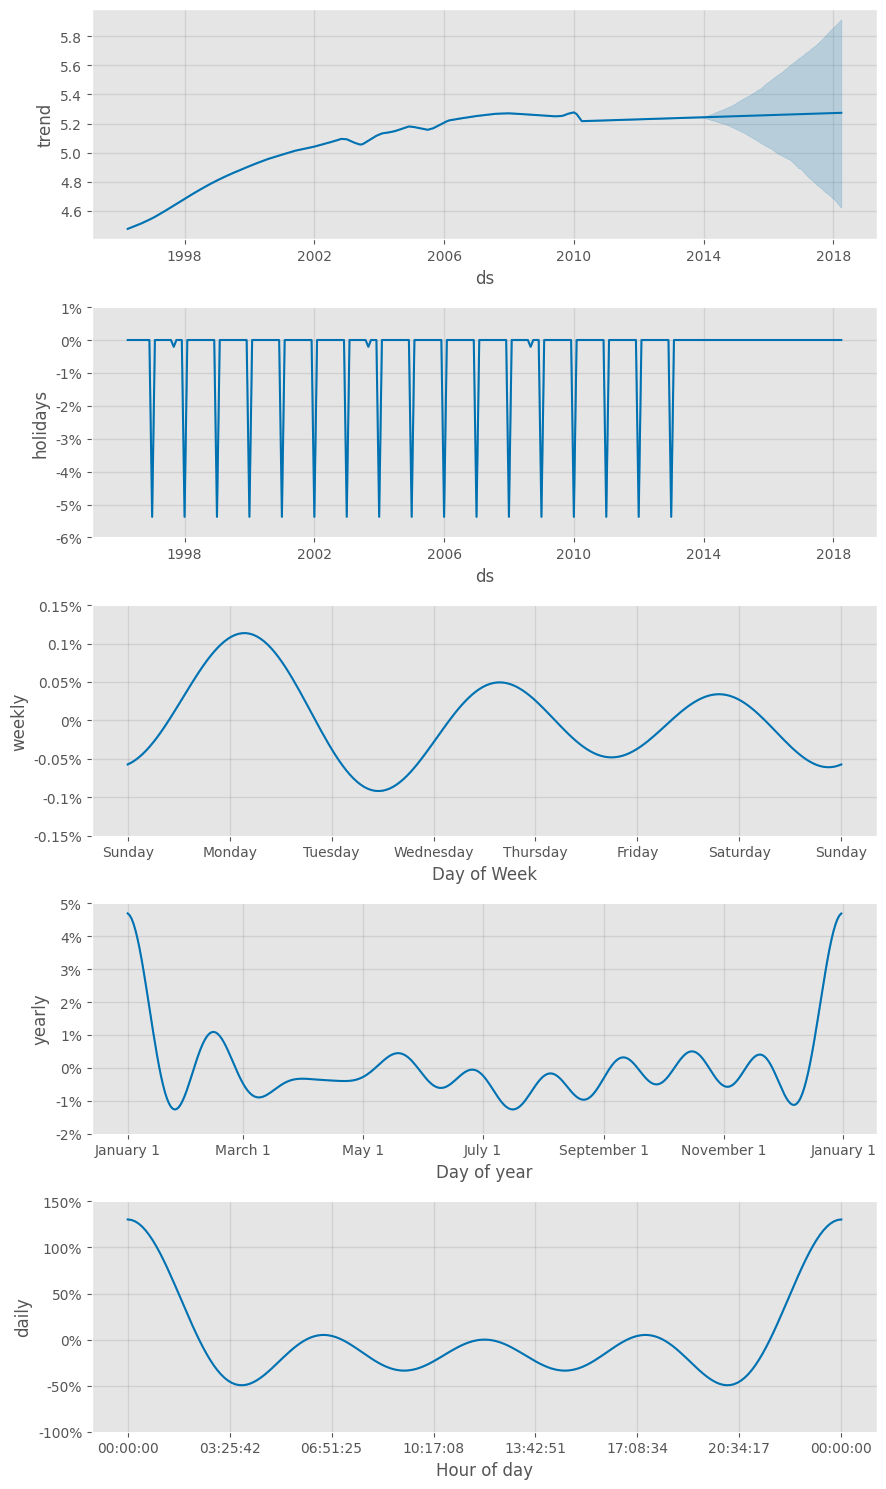

In [646]:
# Plot the components of the model
fig = fb_final_model.plot_components(fb_final_forecast)

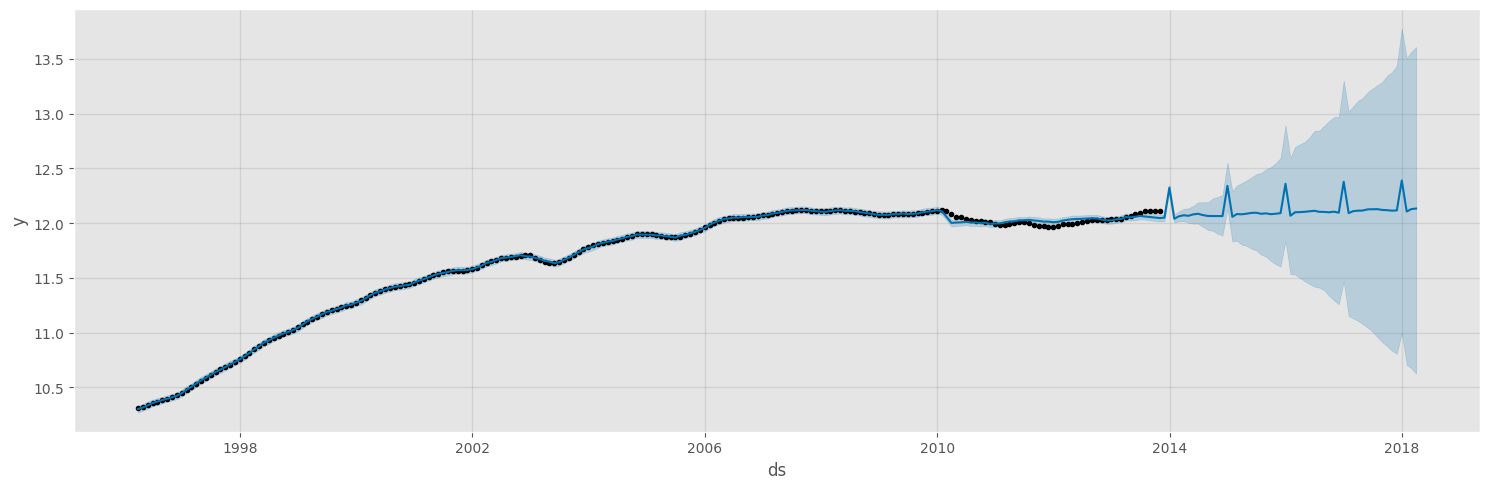

In [647]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = fb_final_model.plot(fb_final_forecast,ax=ax)
plt.show()


In [648]:
fb_final_pred= fb_final_model.predict(fb_test)
fb_final_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
46,2017-10-01,12.116203,10.625690,13.480824
47,2017-11-01,12.112722,10.581331,13.515656
48,2017-12-01,12.106134,10.522765,13.547387
49,2018-01-01,12.115873,10.490509,13.601493
50,2018-02-01,12.118210,10.434986,13.641744
51,2018-03-01,12.125082,10.382849,13.691582
52,2018-04-01,12.129401,10.334868,13.754359


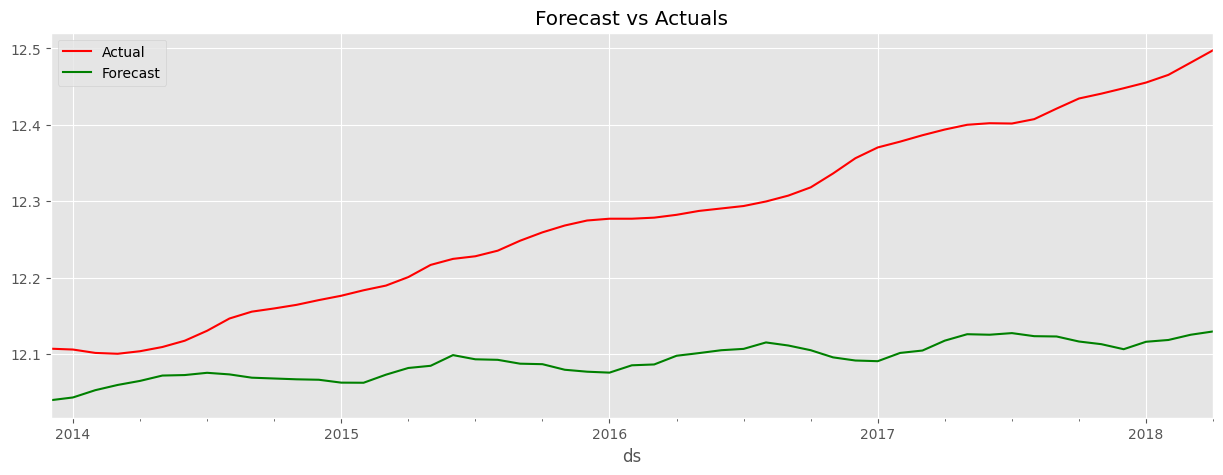

In [649]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
fb_test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
fb_final_pred.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [650]:
# Get the real and predicted values
fb_final_pred = fb_final_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fb_final_pred = fb_final_pred[['yhat','ds']]
fb_final_pred['unlog_value'] = np.exp(fb_final_pred['yhat'])

In [651]:
fb_final_rmse = np.sqrt(mean_squared_error(test['value'], fb_final_pred['unlog_value']))
print(fb_final_rmse)

43909.06837353092


In [652]:
print(f"The RMSE value associated with the base model is {base_rmse}.")
print(f"The RMSE value associated with the AUTO ARIMA model is {arima_rmse}.")
print(f"The RMSE value associated with the Facebook Prophet model is {fb_rmse}.")
print(f"The RMSE value associated with the Tuned Facebook Prophet model is {fb_final_rmse}.")

The RMSE value associated with the base model is 42967.06724835346.
The RMSE value associated with the AUTO ARIMA model is 31204.69249024491.
The RMSE value associated with the Facebook Prophet model is 49199.202762526045.
The RMSE value associated with the Tuned Facebook Prophet model is 43909.06837353092.


# LSTM Neural Network Model

## Transform Time Series to Supervised Learning

In [667]:
series80449

,value
time,
1996-04-01,30000.0
1996-05-01,30400.0
1996-06-01,30900.0
1996-07-01,31400.0
1996-08-01,31800.0
...,...
2017-12-01,254700.0
2018-01-01,256600.0
2018-02-01,259200.0


In [668]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df

In [669]:
# transform to supervised learning
X = series80449.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

         0        0
0      0.0  30000.0
1  30000.0  30400.0
2  30400.0  30900.0
3  30900.0  31400.0
4  31400.0  31800.0


## Transform Time Series to Stationary

In [670]:
supervised_logged = np.log(supervised)
supervised_logged

,0,0
0,-inf,10.308953
1,10.308953,10.322198
2,10.322198,10.338511
3,10.338511,10.354563
4,10.354563,10.367222
...,...,...
260,12.440749,12.447842
261,12.447842,12.455274
262,12.455274,12.465355
263,12.465355,12.481429


In [676]:
supervised_logged.replace([np.inf, -np.inf], 0, inplace=True)

## Transform Time Series to Scale

In [666]:
##scaler = MinMaxScaler(feature_range=(-1,1))
#supervised_scaled = scaler.fit_transform(supervised_logged)

In [658]:
# Define train and test sets according to the index found above
train_sup = supervised_logged[:cutoff]

test_sup = supervised_logged[cutoff:]

In [680]:
train_sup = train_sup.to_numpy()

AttributeError: ignored

In [681]:
test_sup = test_sup.to_numpy()

In [682]:
# scale train and test data to [-1, 1]
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

In [695]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = np.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

In [683]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train_sup, test_sup)

In [690]:
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

## LSTM Model Development

In [692]:
lstm_model = Sequential()
lstm_model.add(LSTM(4, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
#lstm_model.add(LSTM(4, input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X, y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
212/212 - 3s - loss: 0.4021 - 3s/epoch - 16ms/step
Epoch 2/100
212/212 - 0s - loss: 0.3260 - 466ms/epoch - 2ms/step
Epoch 3/100
212/212 - 1s - loss: 0.3215 - 524ms/epoch - 2ms/step
Epoch 4/100
212/212 - 1s - loss: 0.3214 - 568ms/epoch - 3ms/step
Epoch 5/100
212/212 - 1s - loss: 0.3182 - 539ms/epoch - 3ms/step
Epoch 6/100
212/212 - 1s - loss: 0.3137 - 581ms/epoch - 3ms/step
Epoch 7/100
212/212 - 1s - loss: 0.3106 - 619ms/epoch - 3ms/step
Epoch 8/100
212/212 - 1s - loss: 0.3111 - 595ms/epoch - 3ms/step
Epoch 9/100
212/212 - 1s - loss: 0.3071 - 570ms/epoch - 3ms/step
Epoch 10/100
212/212 - 1s - loss: 0.3036 - 509ms/epoch - 2ms/step
Epoch 11/100
212/212 - 0s - loss: 0.3015 - 361ms/epoch - 2ms/step
Epoch 12/100
212/212 - 0s - loss: 0.2992 - 391ms/epoch - 2ms/step
Epoch 13/100
212/212 - 0s - loss: 0.2975 - 394ms/epoch - 2ms/step
Epoch 14/100
212/212 - 0s - loss: 0.2942 - 392ms/epoch - 2ms/step
Epoch 15/100
212/212 - 0s - loss: 0.2911 - 406ms/epoch - 2ms/step
Epoch 16/100
212/212 

## Evaluating the LSTM Model

In [693]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
 X = X.reshape(1, 1, len(X))
 yhat = model.predict(X, batch_size=batch_size)
 return yhat[0,0]

In [698]:
raw_values = series80449.values

In [699]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
 # make one-step forecast
 X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
 yhat = forecast_lstm(lstm_model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 yhat = np.exp(yhat)
 # store forecast
 predictions.append(yhat)
 expected = raw_values[len(train) + i + 1]
 print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 64ms/step
Month=1, Predicted=184120.483930, Expected=180900.000000
1/1 [==============================] - 0s 57ms/step
Month=2, Predicted=181755.193268, Expected=180100.000000
1/1 [==============================] - 0s 69ms/step
Month=3, Predicted=181833.323290, Expected=179900.000000
1/1 [==============================] - 0s 110ms/step
Month=4, Predicted=181194.093459, Expected=180500.000000
1/1 [==============================] - 0s 85ms/step
Month=5, Predicted=181062.078027, Expected=181500.000000
1/1 [==============================] - 0s 66ms/step
Month=6, Predicted=181623.122135, Expected=183000.000000
1/1 [==============================] - 0s 88ms/step
Month=7, Predicted=182580.893729, Expected=185400.000000
1/1 [==============================] - 0s 44ms/step
Month=8, Predicted=184048.209426, Expected=188400.000000
1/1 [==============================] - 0s 77ms/step
Month=9, Predicted=186412.814184, Expected=190100.000000
1/1 [=============

IndexError: ignored

# Forecasting the Future

In [ ]:
# Plug the parameter values from our Auto ARIMA model into a new SARIMAX model that fits the entire series.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                        order=(1,0,2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

NameError: ignored

In [ ]:
## Getting a forecast for the next 36 months after the last recorded date on our dataset.
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

In [ ]:
#Plotting our Forecast

fig, ax = plt.subplots()
recent_series.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 33602 - With Forcasted Value & Confidence Intervals')
plt.show()


# Forecasting on All Top 25 Zip Codes in Clients Budget


In [ ]:
zip_predictions = {}
top_25_for_modeling = top_25_modeling_df.drop(columns='roi_since11')

for zipcode in top_25_for_modeling['RegionName']:

    series = melt_data(top_25_for_modeling[top_25_for_modeling['RegionName']==zipcode])
   
    #Only taking data from 2011 onwards to more accurately reflect current market conditions
    recent_series = series['2011':]
    
    #Splitting the last 36 months of our series as a test dataset.
    train_series = recent_series[:'2016-04']
    test_series = recent_series['2016-05':]
    
    #Auto ARIMA model
    auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
   
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits our entire series.
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    ## Getting a forecast for the next 36 months after the last absrecorded date on our dataset.
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((prediction['prediction'][-1])
                                - (series['value'][-1]))/ (series['value'][-1])

In [ ]:
# Sorting our 3 year ROI forecast for zipcodes into descending order
sort_orders = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
	sorted_forecast_3yr[i[0]] = i[1]

#Selecting only the Top 5 Zips
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

fig, ax = plt.subplots(figsize=(18,12))

x_labels = [top_5_zipcodes[0][0],top_5_zipcodes[1][0],top_5_zipcodes[2][0],
            top_5_zipcodes[3][0],top_5_zipcodes[4][0]]
x = [1,2,3,4,5]
y = [top_5_zipcodes[0][1],top_5_zipcodes[1][1],top_5_zipcodes[2][1],
     top_5_zipcodes[3][1],top_5_zipcodes[4][1]]

ax.bar(x, y, color='mediumslateblue')
remaining_zipcodes = list(sorted_forecast_3yr.items())[5:]
median_ROI_other_zips = remaining_zipcodes[5][1]
ax.axhline(y=median_ROI_other_zips,label = 'Median ROI for remaining Zips')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([(a/100) for a in list(range(0,75,5))])
ax.set_yticklabels([str(a)+'%' for a in list(range(0,75,5))])
ax.set_title('Top 5 Recommendations', fontsize=20)
ax.set_ylabel('Average ROI', fontsize=20)
ax.set_xlabel('Zipcodes',fontsize=20)
ax.legend(prop={'size': 15});

# Conclusion

In [ ]:
print(f'The Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[0][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[0][1])*100,2)}%')
print(f'The Second Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[1][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[1][1])*100,2)}%')
print(f'The Third Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[2][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[2][1])*100,2)}%')
print(f'The Fourth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[3][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[3][1])*100,2)}%')
print(f'The Fifth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[4][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[4][1])*100,2)}%')

In [ ]:
recommended_zips = pd.DataFrame([a for a in sorted_forecast_3yr.keys()][:5])
recommended_zips.columns = ['RegionName']
final_zips_map = pd.merge(recommended_zips, zip_long_lat, how="left", on=["RegionName"])
print(final_zips_map)

In [ ]:
geometry = [Point(xy) for xy in zip(final_zips_map['Longitude'], final_zips_map['Latitude'])] #create Points
geo_df = gpd.GeoDataFrame(final_zips_map, 
                          crs = crs, 
                          geometry = geometry) #define the geometry df

#plot the data
fig, ax = plt.subplots(figsize = (10,10))
us49.to_crs(epsg=4326).plot(ax=ax)
sns.scatterplot(x="Longitude", y="Latitude",data=final_zips_map, ax=ax)
ax.set_title('Distribution of Top 5 Most Profitable Zip Codes');